# Probabilistic ODE solver

## About

This notebook was created to accompany a presentation of
probabilistic ODE solvers for the seminar "Physics-informed Machine Learning" at the University of Tübingen (winter term 2024/2025).

It intends to explain the concept of probabilistic ODE solvers (ODE filters and smoothers) and will guide through a simple implementation of a probabilistic ODE solver.

## References

This tutorial is based on:

- Mostly, esp. the theoretical parts:
  -  Philipp Hennig, Michael A. Osborne, and Hans P. Kersting
    - Probabilistic Numerics: Computation as Machine Learning. Cambridge University Press, 2022
    - DOI [10.1017/9781316681411](https://doi.org/10.1017/9781316681411)
    - Also available for free personal use here: [https://www.probabilistic-numerics.org/textbooks/](https://www.probabilistic-numerics.org/textbooks/)
    - I tried to keep the notation close to theirs
- And also in parts:
  - Filip Tronarp et al.
    - Probabilistic Solutions to Ordinary Differential Equations as Nonlinear Bayesian Filtering: A New Perspective
    - In: Statistics and Computing 29.6 (Nov. 2019), pp. 1297–1315. issn: 1573-1375.
    - DOI [10.1007/s11222-019-09900-1](https://doi.org/10.1007/s11222-019-09900-1)
- The latter parts on numerical stability and the implementation are based on:
  - Nicholas Krämer, Philipp Hennig
  - Stable Implementation of Probabilistic ODE Solvers
  - On ArXiv, Dec. 2020
  - DOI [10.48550/arXiv.2012.10106](https://doi.org/10.48550/arXiv.2012.10106)

Where other sources are used, a reference/link is given.

In [1]:
# Install dependencies here (uncomment first)
# cuda
#!pip install numpy scipy matplotlib 'jax[cuda]' diffrax

# no cuda
#!pip install numpy scipy matplotlib jax diffrax

JAX preallocates 75% of GPU memory.

If you run into OOM errors at the start,
you can try to circumvent this by running this process
(ie. the jupyter server or whatever you use to run the notebook)
with one of these environment variables:

- XLA_PYTHON_CLIENT_MEM_FRACTION=.50 (% of preallocated mem; or set it even lower); or:
- XLA_PYTHON_CLIENT_PREALLOCATE=false (disable preallocation entirely)

See also: [JAX GPU memory allocation](https://docs.jax.dev/en/latest/gpu_memory_allocation.html)

In [2]:
## Setup
import jax
import scipy
import numpy as np
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
from jax.experimental import jet
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
# Use float64 precision
jax.config.update("jax_enable_x64", True)
# higher plot resolution
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
# Plotting functions for later
def plot_lv_with_uncertainty(prob_sol, num_stddevs=2, c_sol=None, title=None):
    predator_col = "red"
    prey_col = "green"
    if c_sol is not None:
        plt.plot(sol.ts, sol.ys, label=None, linewidth=1, color="grey")
    plt.plot(prob_sol["ts"], prob_sol["ys"][:, 0], label="Prey",
             color=prey_col, linewidth=1)
    plt.plot(prob_sol["ts"], prob_sol["ys"][:, 1], label="Predator",
             color=predator_col, linewidth=1)
    plt.fill_between(prob_sol["ts"],
                     prob_sol["ys"][:, 0] - num_stddevs*prob_sol["stddevs"][:, 0],
                     prob_sol["ys"][:, 0] + num_stddevs*prob_sol["stddevs"][:, 0],
                     label=f"Prey $\\pm {num_stddevs}\\sigma$",
                     linewidth=0, color=prey_col, alpha=0.4)
    plt.fill_between(prob_sol["ts"],
                     prob_sol["ys"][:, 1] - num_stddevs*prob_sol["stddevs"][:, 1],
                     prob_sol["ys"][:, 1] + num_stddevs*prob_sol["stddevs"][:, 1],
                     label=f"Predator $\\pm {num_stddevs}\\sigma$",
                     linewidth=0, color=predator_col, alpha=0.4)
    if title is not None:
        plt.title(title)
    plt.legend(prop={'size': 6})
    plt.show()

def plot_filter_and_smoother(f_out, s_out, num_stddevs=2, c_sol=None, title=None):
    predator_col = "red"
    prey_col = "green"
    filter_col = "grey"
    if c_sol is not None:
        plt.plot(sol.ts, sol.ys, label=None, linewidth=1, color="black")
    plt.plot(f_out["ts"], f_out["ys"][:, 0], label="Prey (Filter)",
             color=filter_col, linewidth=1, linestyle="-")
    plt.plot(f_out["ts"], f_out["ys"][:, 1], label="Predator (Filter)",
             color=filter_col, linewidth=1, linestyle="-")
    plt.plot(s_out["ts"], s_out["ys"][:, 0], label="Prey (Smoother)",
             color=prey_col, linewidth=1, linestyle="-")
    plt.plot(s_out["ts"], s_out["ys"][:, 1], label="Predator (Smoother)",
             color=predator_col, linewidth=1, linestyle="-")
    plt.fill_between(f_out["ts"],
                     f_out["ys"][:, 0] - num_stddevs*f_out["stddevs"][:, 0],
                     f_out["ys"][:, 0] + num_stddevs*f_out["stddevs"][:, 0],
                     #label=f"Prey (Filter) $\\pm {num_stddevs}\\sigma$",
                     label=None,
                     linewidth=0, color=filter_col, alpha=0.3)
    plt.fill_between(f_out["ts"],
                     f_out["ys"][:, 1] - num_stddevs*f_out["stddevs"][:, 1],
                     f_out["ys"][:, 1] + num_stddevs*f_out["stddevs"][:, 1],
                     #label=f"Predator (Filter) $\\pm {num_stddevs}\\sigma$",
                     label=None,
                     linewidth=0, color=filter_col, alpha=0.3)
    plt.fill_between(s_out["ts"],
                     s_out["ys"][:, 0] - num_stddevs*s_out["stddevs"][:, 0],
                     s_out["ys"][:, 0] + num_stddevs*s_out["stddevs"][:, 0],
                     label=f"Prey (Smoother) $\\pm {num_stddevs}\\sigma$",
                     linewidth=0, color=prey_col, alpha=0.4)
    plt.fill_between(s_out["ts"],
                     s_out["ys"][:, 1] - num_stddevs*s_out["stddevs"][:, 1],
                     s_out["ys"][:, 1] + num_stddevs*s_out["stddevs"][:, 1],
                     label=f"Predator (Smoother) $\\pm {num_stddevs}\\sigma$",
                     linewidth=0, color=predator_col, alpha=0.4)
    if title is not None:
        plt.title(title)
    plt.legend(prop={'size': 6})
    plt.show()

## Background

### Ordinary Differential Equations (ODEs)

_Here_, an ODE is a function
$$ y'(t) = f(y(t)) \in \mathbb{R}^d\,, t \in [0, T]\,, $$
and we want to solve it by finding a curve
$$ y: [0, T] \rightarrow \mathbb{R}^d $$
with initial value
$$ y(0) = y_0 $$
that satisfies this equation.

This means that, as opposed to general ODEs, we require,
mainly to keep the theoretical parts simple:

- The ODE only contains the first derivative $y'(t)$, no higher-order derivatives
  - ie. we only consider _first-order_ ODEs
  - This comes without loss of generality:
    - all higher-order ODEs can be rewritten as first-order ODE
    - But: the solver _could_ be extended to also consider higher-order ODE information
- $f$ does not depend on $t$ ($\rightarrow$ autonomous ODE)
  - Also no loss of generality
    - Again, every ODE can be transformed into autonomous form
- The equation given above is in _explicit_ form
  - we won't consider _implicit_ ODEs (ie. of form $ f(y(t), y'(t)) = 0 $)
- A known initial value, so we are actually interested in an ODE _initial value problem_ (IVP)

#### Lotka-Volterra system

The Lotka-Volterra system/equations model predator/prey-populations as a 2-dimensional ODE:
\begin{align*}
    y_1'(t) &= \alpha y_1(t) - \beta y_1(t) y_2(t) \\
    y_2'(t) &= -\gamma y_2(t) + \delta y_1(t) y_2(t)
\end{align*}

Where:
- $y_1$ is the population density/size of the prey
- $y_2$ is the population density of the predator
  - $\alpha$: prey growth rate
  - $\gamma$: predator death rate
  - $\beta$: effect of predator population density on prey death rate
  - $\delta$: effect of prey population density on predator growth rate

For more details, see eg. [Lotka–Volterra equations (Wikipedia)](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

Let's see an example of it, using a classical ODE solver
(code taken from [Diffrax documentation](https://docs.kidger.site/diffrax/examples/coupled_odes/)):

In [4]:
@partial(jax.jit, static_argnames=["args"])
def lotka_volterra_vf(t, y, args):
    prey, predator = y[..., 0], y[..., 1]
    alpha, beta, gamma, delta = args
    d_prey: Array = alpha * prey - beta * prey * predator
    d_predator: Array = -gamma * predator + delta * prey * predator
    return jnp.array([d_prey, d_predator])

In [5]:
t0 = 0
t1 = 140
y0 = jnp.array([10.0, 10.0])
lv_args = (0.1, 0.02, 0.4, 0.02)

In [6]:
term = ODETerm(lotka_volterra_vf)
solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
dt0 = 0.1
sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=lv_args, saveat=saveat)

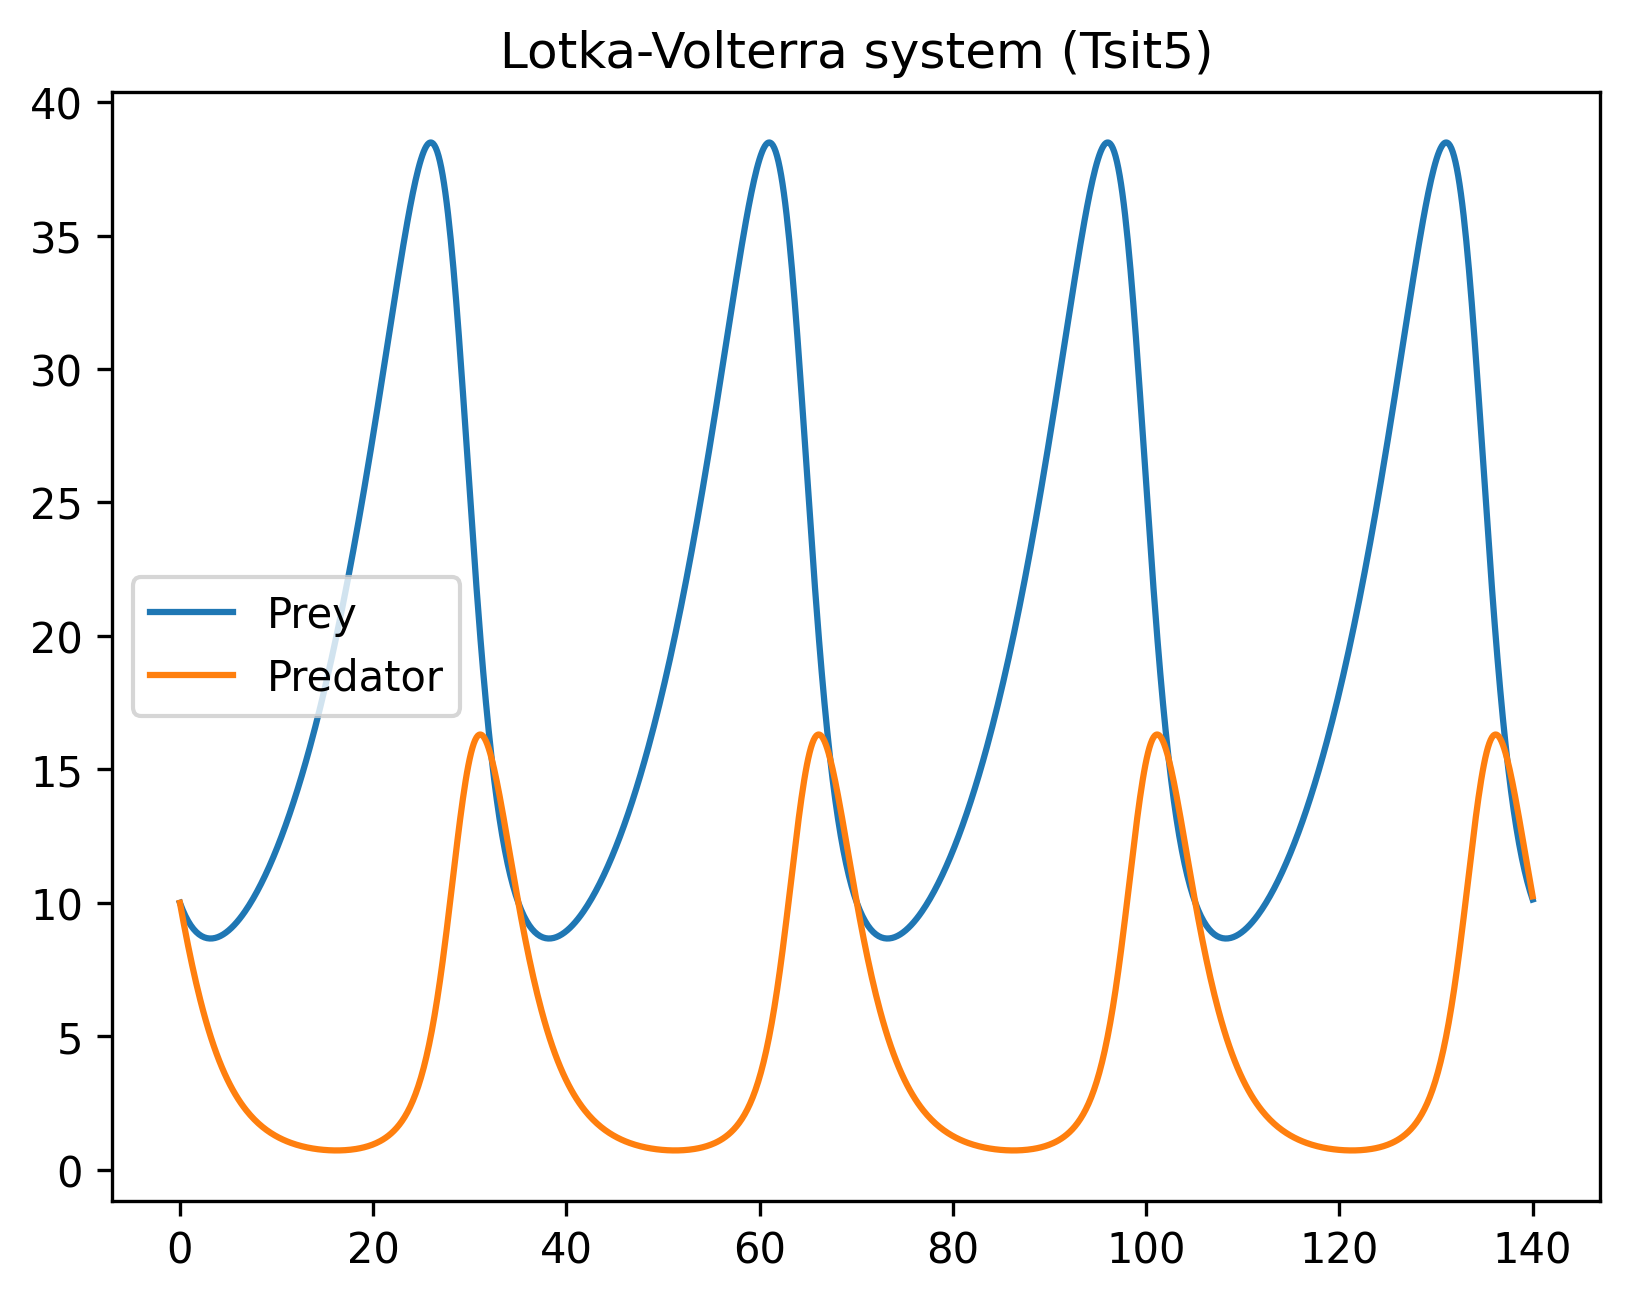

In [7]:
plt.plot(sol.ts, sol.ys, label=["Prey", "Predator"])
plt.legend()
plt.title("Lotka-Volterra system (Tsit5)")
plt.show()

### Classical ODE solvers

#### How do they work?

- Work on discrete time steps:
  $$ 0 = t_0 < t_1 < \ldots < t_N = T\,, \text{ with step sizes: } h_n = t_n - t_{n - 1} $$
- Iteratively perform steps:
  - At step $n$, we have $\hat{y}(t_{n-1}) \approx y(t_{n-1})$
  - Estimate derivative $y'(t_{n-1}) = f(y(t_{n-1})) \approx f(\hat{y}(t_{n-1}))$
    - Potentially use more information
    - Eg. approximate higher-order derivatives
  - Construct approximation to $\hat{y}(t_n) = \hat{y}(t_{n-1} + h_n)$
    - Using derivative information/other information
    - Example: Eulers method
      - $\hat{y}(t_{n-1} + h_n) \approx \hat{y}(t_{n-1}) + h_n f(\hat{y}(t_{n-1}))$
      - First-order Taylor expansion (linear approximation) of $\hat{y}(t_{n-1} + h_n)$

#### Order

An ODE solver of order $q$

- essentially fits a $q$-th order Taylor expansion
- thus has _local_ error (or convergence rate) $\mathcal{O}(h^{q+1})$

### Probabilistic viewpoint: Viewing ODE solving as regression

One can view solving an ODE as regression on
$$ \mathcal{D} = \left\{x(0) = x_0, x'(t_n) = f(\hat{x}(t_n)) \mid
n \in \{0, \ldots, N\}\right\} $$
(that is, all the data available to the solver),
where the goal is to find a function $x$ that fulfills all of these equations,
and the data is revealed to the solver progressively.

## Probabilistic ODE solvers

### Why?

- Classical solvers treat the current estimate $\hat{y}(t_n) \approx y(t_n)$
  as the true value when taking a step, without taking into account eg.
  accumulated numerical errors
  - Probabilistic solvers provide a very natural way of expressing uncertainty
    - Not only do you get an estimate of uncertainty in the solution, but:
    - The solver can make use of that information while solving the ODE
- They also allow to model uncertainty in more than just the solution, for example
  - Uncertainty in the initial value $y_0$
  - Or some uncertainty in the ODE itself

### GP Regression

Jointly model $y(t)$ and $y'(t)$ in a state vector:
$$ \begin{pmatrix} y(t) \\ y'(t) \end{pmatrix} = x(t) \sim \mathcal{GP}(\bar{x}, k) $$
with mean function $\bar{x}(t)$ and kernel function $k(t_1, t_2)$.

How to perform inference efficiently?
- In complexity $\mathcal{O}(N)$
  - instead of $\mathcal{O}(N^3)$ for traditional GP regression
- How to take advantage of the derivative information?

$\rightarrow$ we need a sensible prior

### Model ODE solution in Continuous-Time State Space Model (SSM)

We can model the state vector $x(t) \in \mathbb{R}^{q}$ by a stochastic process:
$$ x(t) \sim X(t) $$
and introduce projections $H_0, H \in \mathbb{R}^{d \times (q+1)}$ such that

\begin{align*}
    y(t) &= H_0 x(t) \\
    y'(t) &= H x(t) \,.
\end{align*}

Since we are interested in IVPs, we also model the initial value by
$$ X(0) \sim \mathcal{N}(m_0, P_0) $$
(more details later on).

An example where $x$ models $y(t)$ and its first three derivatives (ie. $q = 3$):

\begin{align*}
    H_0 &= \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \\
    H &= \begin{bmatrix} 0 & 1 & 0 & 0 \end{bmatrix} \\
    x(t) &= \begin{pmatrix} y(t) \\ y'(t) \\ y''(t) \\ y'''(t) \\ \end{pmatrix} \sim X(t)
\end{align*}

We can build the projection matrices as follows:

In [8]:
def ssm_projection_matrices(d, q):
    # Projections: project SSM state -> y (H0) or SSM state -> y' (H)
    H0 = jnp.zeros((1, q + 1)).at[0, 0].set(1.0)
    H = jnp.zeros((1, q + 1)).at[0, 1].set(1.0)
    Id = jnp.eye(d)  # Ignore this and below for now.
    H0 = jnp.kron(H0, Id)
    H = jnp.kron(H, Id)
    return H0, H

#### Dynamic model / State

We now let $X(t)$ follow this linear, time-invariant SDE:
$$ dx(t) = Fx(t)dt + Ld\omega_t $$
where $ F = \begin{bmatrix} 0&1&0&0 \\ 0&0&1&0 \\ 0&0&0&1 \\ 0&0&0&0 \end{bmatrix} $
and $ L = \begin{pmatrix} 0 \\ 0 \\ 0 \\ \sigma \end{pmatrix} $, and $d\omega_t$
can be informally thought of as "increment of the Wiener process";
integrating over it yields the Wiener process, ie. the random walk.

This gives rise to an interesting structure:

- all elements in $x(t)$ are derivatives of each other for all $t$
- $y'''(t)$ is modeled as random walk with scale $\sigma$
  (as its derivative is the increment of the Wiener process)

Because:
$$
dx(t)
= \begin{bmatrix} 0&1&0&0 \\ 0&0&1&0 \\ 0&0&0&1 \\ 0&0&0&0 \end{bmatrix}
\begin{pmatrix} y(t) \\ y'(t) \\ y''(t) \\ y'''(t) \\ \end{pmatrix} dt
+ \begin{pmatrix} 0 \\ 0 \\ 0 \\ \sigma \end{pmatrix} d\omega_t
= \begin{pmatrix} y'(t)dt \\ y''(t)dt \\ y'''(t)dt \\ d\omega_t \end{pmatrix}
$$

This means that $x(t)$ now models some function $y(t)$ and its $q=3$ first
derivatives, and $y'''(t)$ is modeled as Wiener process/random walk.

Thus, this Prior is known as the $q$-times integrated Wiener process (with scale $\sigma$).

Also, as is evident above, the $q$-times IWP prior is a GP that satisfies the Markov property
(referred to as Gauss-Markov process).

#### Measurement model (Information operator)

To our dynamic model, we now add a measurement model.

We define:
$$ z(t) \sim Z(t) := g(X(t)) := HX(t) - f(H_0 X(t))\,, $$
so
$$ z(t) = g(x(t)) = Hx(t) - f(H_0 x(t)) = y'(t) - f(y(t))\,, $$
which is referred to as the _state misalignment_.

$Z$ now serves as _information operator_:
It extracts information about the the state misalignment $z(t)$ from the ODE,
quantifying the "correctness" of $y$.

#### Likelihood

Now, we have our prior (the $q$-times IWP), and a measurement model (through the information operator).

As seen above, $z(t) = y'(t) - f(y(t))$, which means that iff $y$ is a solution to the ODE (ie. $y'(t) = f(y(t))$ for all $t$; and of course also $y(0) = y_0$),
then $z(t) = 0$.

Thus, if we use the likelihood
$$ p(z(t) \mid x(t)) = \delta(g(x(t))) = \delta(Hx(t) - f(H_0 x(t))) = \delta(y'(t) - f(y(t)))\,, $$
then, if we simply observe the data $0 = z(t)$ for all $t$,
the posterior $p(x \mid z = 0)$ contains the solution (also with zero uncertainty).

Now, we have modeled the ODE (solution) as a _filtering problem_,
and inference in this setting and observations $z(t) = 0$ does
recover the ODE solution.

### Discrete-time version of the SSM

Of course, inference in this model is intractable,
we can only work on discrete (and finitely many) points $t_n$;
for tractable inference, we need to discretize the above continuous-time SSM:

With functions of $t_n$ now denoted by subscript $n$ (eg. $x(t_n) := x_n$),
the above can be discretized into
\begin{align}
    p(x_0) &= \mathcal{N}(x_0; m_0, P_0) &\text{Initial value}\\
    p(x_{n+1} \mid x_n) &= \mathcal{N}(x_{n+1}; A(h_{n+1})x_n, Q(h_{n+1})) &\text{Dynamics}\\
    p(z_n \mid x_n) &= \delta(z_n - g(x_n)) &\text{Observations (information operator)}
\end{align}

Or, alternatively,
\begin{align}
    p(z_n \mid x_n) &= \mathcal{N}(z_n; g(x_n), R) &\text{Observations (information operator)}\,,
\end{align}
which is less general (but the variance $R$ can help in some cases),
and, if the vector field $f$ is linear, this is a linear Gaussian SSM (as $g$ then is linear too).

In the discretized SSM, we have $A(h_n), Q(h_n)$ given by
\begin{align*}
    A(h_n)_{i,j} &= \mathbb{I}(j \geq i) \frac{h_n^{j-i}}{(j-i)!} &\text{Transition matrix}\\
    Q(h_n)_{i,j} &= \sigma^2 \frac{h_n^{2q + 3 - i - j}}{(2q + 3 - i - j)(q + 1 - i)!(q + 1 - j)!} &\text{Diffusion matrix}
\end{align*}

What does this mean?

Consider again the example from above:
$$ x_n = \begin{pmatrix} y_n \\ y'_n \\ y''_n \\ y'''_n \end{pmatrix}\,, $$
then, with $h := h_{n+1}, A := A(h_{n+1})$ for less clutter:
$$ (Ax_n)_1 =
\begin{bmatrix}\frac{h^0}{0!} & \frac{h^1}{1!} & \frac{h^2}{2!} & \frac{h^3}{3!}\end{bmatrix}
\begin{pmatrix} y_n \\ y'_n \\ y''_n \\ y'''_n \end{pmatrix}
= y_n + h y'_n + \frac{h^2}{2} y''_n + \frac{h^3}{6} y'''_n\,, $$
which is a $q=3$-rd order Tayler expansion of $y(t_n + h_{n+1})$.

- Thus, we'll also get a solver of order $q$ (and local error $\mathcal{O}(h^{q+1})$)
  - This is _just for illustration_, absolutely not a proof

In [9]:
def discrete_transition_matrix(d, q, h):
    A_exponents = jnp.stack([jnp.arange(q + 1) - i for i in range(q + 1)])
    A = jnp.triu(h ** A_exponents / jax.scipy.special.factorial(A_exponents))
    return jnp.kron(A, jnp.eye(d))  # Ignore everything about d/this line for now

def discrete_diffusion_matrix(d, q, h):
    Q_j = jnp.stack((jnp.arange(q + 1) + 1,) * (q + 1))
    Q_exponent = 2 * q + 3 - Q_j.T - Q_j
    Q_divisor_j = jax.scipy.special.factorial(q + 1 - Q_j)
    Q = (h ** Q_exponent  # Note the absence of the \sigma^2 factor,
         / (Q_exponent    # we'll come back to this
             * Q_divisor_j
             * Q_divisor_j.T))
    return jnp.kron(Q, jnp.eye(d))  # Ignore everything about d/this line for now

In [10]:
# Here's an example with q=2 and h=0.1:
A_ex = discrete_transition_matrix(1, 2, 0.1)
Q_ex = discrete_diffusion_matrix(1, 2, 0.1)
print(f"A:\n{A_ex}")
print(f"Q:\n{Q_ex}")

A:
[[1.    0.1   0.005]
 [0.    1.    0.1  ]
 [0.    0.    1.   ]]
Q:
[[5.00000000e-07 1.25000000e-05 1.66666667e-04]
 [1.25000000e-05 3.33333333e-04 5.00000000e-03]
 [1.66666667e-04 5.00000000e-03 1.00000000e-01]]


#### Why use state misalignment z and not condition on $f(H_0 x_n)$ directly?

- This separates the observations from the implementation/algorithm, ie. we observe the data $z_n = 0$ for _any_ implementation
  - If we changed the observations to:
    - $\tilde{z}_n = Hx_n$
    - and want to observe that $\tilde{z}_n = f(H_0 x_n)$ directly
  - then the observations/data that we condition on depend on the algorithm
    - as $x_n$, the current solution/state, depends on the algorithm in use
    - so every algorithm would operate on different observations

## Filtering and Smoothing

### Kalman (ODE) Filter

For now, let's first consider the linear Gaussian SSM case from above:
\begin{align}
    p(x_0) &= \mathcal{N}(x_0; m_0, P_0) &\text{Initial value}\\
    p(x_{n+1} \mid x_n) &= \mathcal{N}(x_{n+1}; A(h_{n+1})x_n, Q(h_{n+1})) &\text{Dynamics}\\
    p(z_n \mid x_n) &= \mathcal{N}(z_n; g(x_n), R) &\text{Observations (information operator)}\end{align}

On this, we can directly perform Bayesian inference.
As the SSM is Markovian, we can perform filtering by iterating two steps:

- Predict: $p(x_{n+1} | z_{0:n}) = \int p(x_{n+1} | x_n)p(x_n | z_{0:n}) dx_n$ (Chapman-Kolmogorov Eq.)
- Observe the next $z_{n+1}$
  - Actually: observe that $z_{n+1} = 0$
  - So we don't really need to do anything
- Update: $p(x_{n+1} | z_{0:n+1}) = \frac{p(z_{n+1} | x_{n+1})p(x_{n+1} | z_{0:n})}{p(z_{n+1}|z_{0:n})}$

As (for now) everything is linear Gaussian, the above just boils down
to a little bit of linear algebra:

#### Prediction Step

$$ p(x_{n+1} | z_{0:n}) = \mathcal{N}(x_{n+1}; m_{n+1}^p, P_{n+1}^p) $$
where
\begin{align*}
    m_{n+1}^p &= A(h_{n+1}) m_n^f &\text{predictive mean}\\
    P_{n+1}^p &= A(h_{n+1}) P_n^f A(h_{n+1})^\top + Q(h_{n+1}) &\text{predictive cov}\,,
\end{align*}
and this is simply implemented by

In [11]:
def predict(m_f, P_f, A, Q):
    m_p = A @ m_f  # predictive mean
    P_p = A @ P_f @ A.T + Q  # predictive cov
    return m_p, P_p

#### Exact Update Step ($f$ linear)

$$ p(x_{n+1} | z_{0:n+1}) = \mathcal{N}(x_{n+1}; m_{n+1}^f, P_{n+1}^f) $$
where
\begin{align*}
    \hat{z}_{n+1} &= f(H_0 m_{n+1}^p) - Hm_{n+1}^p &\text{innovation residual} \\
    \tilde{H} &= H &\text{(for now)} \\
    S_{n+1} &= \tilde{H} P_{n+1}^p \tilde{H}^\top + R &\text{innovation cov} \\
    K_{n+1} &= P_{n+1}^f \tilde{H}^\top S_{n+1}^{-1} &\text{Kalman gain} \\
    m_{n+1}^f &= m_{n+1}^p + K_{n+1} \hat{z}_{n+1}  &\text{filtering mean} \\
    P_{n+1}^f &= (I_D - K_{n+1} \tilde{H}) P_{n+1}^p &\text{filtering cov} \,.
\end{align*}

As long as $f$ is linear, everything stays linear Gaussian.
- This is known as the _Kalman filter_
- And is exact

Before we implement this: What can we do for nonlinear $f$?

#### Extended Kalman ODE Filter (EKF0, EKF1)

We need to stay linear Gaussian, but our $f$ now is nonlinear :(

What to do now?
- We can just approximate $f$ around $H_0 m_{n+1}^p$ by a linear function, then do the above
- Thus, the update is now no longer exact, but:
  - This is very cheap
  - and often accurate enough

This is known as Extended Kalman (ODE) Filter (EKF).

We have two choices for our approximation of $f$:
- constant function (order 0 Taylor expansion)
  - EKF0
  - $f(H_0 m_{n+1}^p + y) \approx f(H_0 m_{n+1}^p)$
- linear function (order 1 Taylor expansion)
  - EKF1
  - $f(H_0 m_{n+1}^p + y) \approx f(H_0 m_{n+1}^p) + J_f(H_0 m_{n+1}^p)(y - H_0 m_{n+1}^p)$

From this, we obtain two choices for the EKF update step:

\begin{align*}
    \hat{z}_{n+1} &= f(H_0 m_{n+1}^p) - Hm_{n+1}^p &\text{innovation residual} \\
    \tilde{H} &= \begin{cases}H &\text{EKF0} \\ H - J_f(H_0 m_{n+1}^p) H_0 &\text{EKF1}\end{cases} &\text{cov. of $z_{n+1}$ after approximation}\\
    S_{n+1} &= \tilde{H} P_{n+1}^p \tilde{H}^\top + R &\text{innovation cov} \\
    K_{n+1} &= P_{n+1}^f \tilde{H}^\top S_{n+1}^{-1} &\text{Kalman gain} \\
    m_{n+1}^f &= m_{n+1}^p + K_{n+1} \hat{z}_{n+1}  &\text{filtering mean} \\
    P_{n+1}^f &= (I_D - K_{n+1} \tilde{H}) P_{n+1}^p &\text{filtering cov} \,.
\end{align*}

With that, we can directly implement the update:

Calculate:
\begin{align*}
    \hat{z}_{n+1} &= f(H_0 m_{n+1}^p) - Hm_{n+1}^p &\text{innovation residual} \\
    \tilde{H} &= \begin{cases}H &\text{EKF0} \\ H - J_f(H_0 m_{n+1}^p) H_0 &\text{EKF1}\end{cases} &\text{cov. of $z_{n+1}$ after approximation}\\
\end{align*}

In [12]:
def residual(f, t, m_p, H, H0, f_args, ekf_order):
    # returns the innovation residual/state misalignment
    m_p0 = H0 @ m_p
    f_at_m_p = f(t, m_p0, f_args)
    if ekf_order == 0:
        H_hat = H
    else:
        # ekf_order == 1
        # Calculate Jacobian of f with forward mode AD
        J_f = jax.jacfwd(f, argnums=1)(t, m_p0, f_args)
        H_hat = H - J_f @ H0  # regular * in 1-d case
    z_hat = f_at_m_p - H @ m_p  # residual
    return z_hat, H_hat  # H_hat: \tilde{H} from above

Calculate:
\begin{align*}
    S_{n+1} &= \tilde{H} P_{n+1}^p \tilde{H}^\top + R &\text{innovation cov (intermediate)} \\
    K_{n+1} &= P_{n+1}^f \tilde{H}^\top S_{n+1}^{-1} &\text{Kalman gain (intermediate)} \\
    m_{n+1}^f &= m_{n+1}^p + K_{n+1} \hat{z}_{n+1}  &\text{filtering mean (result)} \\
    P_{n+1}^f &= (I_D - K_{n+1} \tilde{H}) P_{n+1}^p &\text{filtering cov (result)} \,.
\end{align*}

In [13]:
def next_filtering_mean_and_cov(m_p, P_p, z_hat, H_hat, R):
    # Kalman filter statistics
    S = H_hat @ P_p @ H_hat.T + R
    S_inv = jnp.linalg.inv(S)  # Yes, inverse here. We'll improve this later.
    K = P_p @ H_hat.T @ S_inv
    # Filtering mean/cov
    m_f = m_p + K @ z_hat
    P_f = (jnp.eye(P_p.shape[1]) - K @ H_hat) @ P_p
    return m_f, P_f

#### Filter step

Thus, we can build a full filter step (predict, then update) with:

In [14]:
# jit compile this function for speedup
@partial(jax.jit, static_argnames=["f", "f_args", "d", "q", "ekf_order"])
def ode_filter_step(m_f_prev, P_f_prev, f, f_args,
                    t_prev, h, d, q,
                    H0, H, R, ekf_order):
    # calculate next time step
    t = t_prev + h
    # Get discretization for stepsize h:
    A = discrete_transition_matrix(d, q, h)
    Q = discrete_diffusion_matrix(d, q, h)
    # predict
    m_p, P_p = predict(m_f_prev, P_f_prev, A, Q)
    # update
    z_hat, H_hat = residual(f, t, m_p, H, H0, f_args, ekf_order)
    m_f, P_f = next_filtering_mean_and_cov(m_p, P_p, z_hat, H_hat, R)
    # Also extract and return the current (filtering) y and its stddev
    y = H0 @ m_f
    stddev = jnp.sqrt(jnp.diag(H0 @ P_f @ H0.T))
    return m_f, P_f, m_p, P_p, y, stddev

#### How to get the initial state vector?

Remember, the state vector $x_n$ contains $y_n$ and $y'_n$,
and, if we want, derivatives up to $y^{(q)}_n$.

If $q = 1$, then it is obvious that $x_0 = \begin{pmatrix} y_0 & f(y_0) \end{pmatrix}^\top$,
but how do we handle higher $q$?
- The elements of $x$ are, and stay, derivatives of each other, so we need to initialize
  the first mean with higher-order derivatives as follows:
  $$ m_0^f = \begin{pmatrix} y_0 & f^{\langle 1 \rangle}(y_0) & f^{\langle 2 \rangle}(y_0) & \ldots & f^{\langle q \rangle}(y_0)\end{pmatrix}^\top\,, $$
  where
  \begin{align*}
    f^{\langle 1 \rangle}(y) &= f(y)\,, \\
    f^{\langle i \rangle}(y) &= \frac{d}{dy} \left( f^{\langle i-1 \rangle}(y) \cdot f(y) \right) & \text{(for $i>1$)}\,.
  \end{align*}
  This is exponentially (in $q$) expensive with regular AD,
  but can be more efficiently calculated using Taylor-mode AD, in JAX implemented in ```jet.jet()```.


If interested, more details can be found in [Bettencourt, Johnson, Duvenaud (2019)](https://openreview.net/pdf?id=SkxEF3FNPH]).

- This is the only thing we need to worry about (apart from stability issues, maybe addressed at the end)

Here's an implementation:

In [15]:
def initial_state(f, t0, y0, q, f_args):
    # Return [y0, f^<i>(y0)] as defined above
    def f_wrapped(y):
        # make f a function of y only (so it works with jet)
        return f(t0, y, f_args)
    y0_tup = (y0,)  # jet wants this in a tuple
    # y_is will now iteratively be filled like this:
    # (f(y0), f^<1>(y0), f^<2>(y0))  ->  (f(y0),) + (f^<1>(y0), f^<2>(y0), f^<3>(y0))
    y_is = (f_wrapped(y0),)
    for _ in range(q - 1):
        y_i_new, y_is_new = jet.jet(f_wrapped, y0_tup, (y_is,))
        # above returns tuple[Array, list[Array]], put all into one tuple
        y_is = (y_i_new,) + (*y_is_new,)
    return jnp.stack((y0_tup) + y_is).flatten()

#### How to fit higher-dimensional y? (ie. an ODE system)

If $y$ is $d$-dimensional, then we can just stack everything, using the Kronecker product $\otimes$,
with
$$
    \mathbf{A} = A \otimes I_d
       = \begin{bmatrix}
          a_{1,1}I_d & \cdots & a_{1,q+1}I_d \\
          \vdots & \ddots & \vdots \\
          a_{q+1,1}I_d & \cdots & a_{q+1,q+1}I_d
         \end{bmatrix} \in \mathbb{R}^{d(q+1)\times d(q+1)}\,.
$$
For example, for $d=2, q=1$, we have
$$ \mathbf{x} = \begin{pmatrix} y_1 \\ y_2 \\ y_1' \\ y_2' \end{pmatrix}\,, $$
and $\mathbf{A} = A \otimes I_2$.

The functions given above for $A, Q, H, H_0$ already do this, so let's see what this means:

In [16]:
x1 = jnp.array([0.0, 2.0])  # the first dimension
x2 = jnp.array([1.0, 3.0])  # the second dimension
x_s = jnp.stack([x1, x2]).T.flatten()
A = discrete_transition_matrix(1, 1, 0.1)
A_s = discrete_transition_matrix(2, 1, 0.1)
print(f"x1: {x1}, x2: {x2}")
print(f"x_s: {x_s}")
print(f"A:\n{A}")
print(f"A_s:\n{A_s}")
print(f"Ax1: {A@x1}, Ax2: {A@x2}")
print(f"Ax1, Ax2 stacked: {jnp.stack([A@x1, A@x2]).T.flatten()}")
print(f"A_s x_s: {A_s@x_s}")

x1: [0. 2.], x2: [1. 3.]
x_s: [0. 1. 2. 3.]
A:
[[1.  0.1]
 [0.  1. ]]
A_s:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
Ax1: [0.2 2. ], Ax2: [1.3 3. ]
Ax1, Ax2 stacked: [0.2 1.3 2.  3. ]
A_s x_s: [0.2 1.3 2.  3. ]


Essentially, this means that all of the stacked operators
just operate _per dimension_ as they would normally
in the one-dimensional case.

- This means that we don't need to care about $d$ anywhere,
  as long as we stack the state and the operators correctly,
  the math stays exactly the same.
- To my understanding, this also means that every dimension
  is modeled independently of each other
  - For example, we don't get covariances between different dimensions,
    or rather, it is zero
  - In the prior, every dimension is a $q$-times IWP independently
    of every other dimension

#### ODE Filter

Now, we can build our first probabilistic ODE solver
- with constant stepsize $h$
- no error estimation etc.
- lots of other points we can adress later

A simple version of an ODE filter:

In [17]:
def ode_filter(y0, f, f_args,
               t0, t1,
               q,  # order
               h,
               ekf_order=1):
    h, t0 = jnp.array(h), jnp.array(t0)  # Ensure these are arrays
    d = y0.shape[-1]  # dimension of y
    # Initialization
    x0 = initial_state(f, t0, y0, q, f_args)
    stddev0 = jnp.zeros_like(y0)
    P0 = jnp.diag(jnp.repeat(stddev0, q + 1))  # Assume zero initial cov.
    H0, H = ssm_projection_matrices(d, q)
    # R=0 -> dirac measure on initial value
    R = jnp.zeros((d, d))
    # Init. objects for storing results
    ts, ys, stddevs = [t0], [y0], [stddev0]
    filtering_means, filtering_covs, predictive_means, predictive_covs = [x0], [P0], [], []
    # Init. loop variables
    t_prev = t0
    m_f_prev, P_f_prev = x0, P0  # Filtering parameters (of previous step)

    # The ODE filter loop
    while t_prev < t1:
        m_f, P_f, m_p, P_p, y, stddev = \
            ode_filter_step(m_f_prev, P_f_prev, f, f_args,
                            t_prev, h, d, q,
                            H0, H, R, ekf_order)
        # Store results
        t = t_prev + h
        ts.append(t)
        ys.append(y)
        stddevs.append(stddev)
        filtering_means.append(m_f)
        filtering_covs.append(P_f)
        predictive_means.append(m_p)
        predictive_covs.append(P_p)
        # Update loop variables
        t_prev, m_f_prev, P_f_prev = t, m_f, P_f

    # Return results in dict
    return {
        "ts": jnp.asarray(ts).squeeze(),
        "ys": jnp.asarray(ys).squeeze(),
        "stddevs": jnp.asarray(stddevs).squeeze(),
        "predictive_means": predictive_means,
        "predictive_covs": predictive_covs,
        "filtering_means": filtering_means,
        "filtering_covs": filtering_covs,
        "H0": H0, "d": d, "q": q}

In [18]:
q = 1
h = 1e-1  # If we decrease the stepsize, this is very accurate already
#h = 1e-2
ekf_order = 1
f_sol = ode_filter(
    y0, lotka_volterra_vf, lv_args,
    t0, t1, q, h, ekf_order=ekf_order)

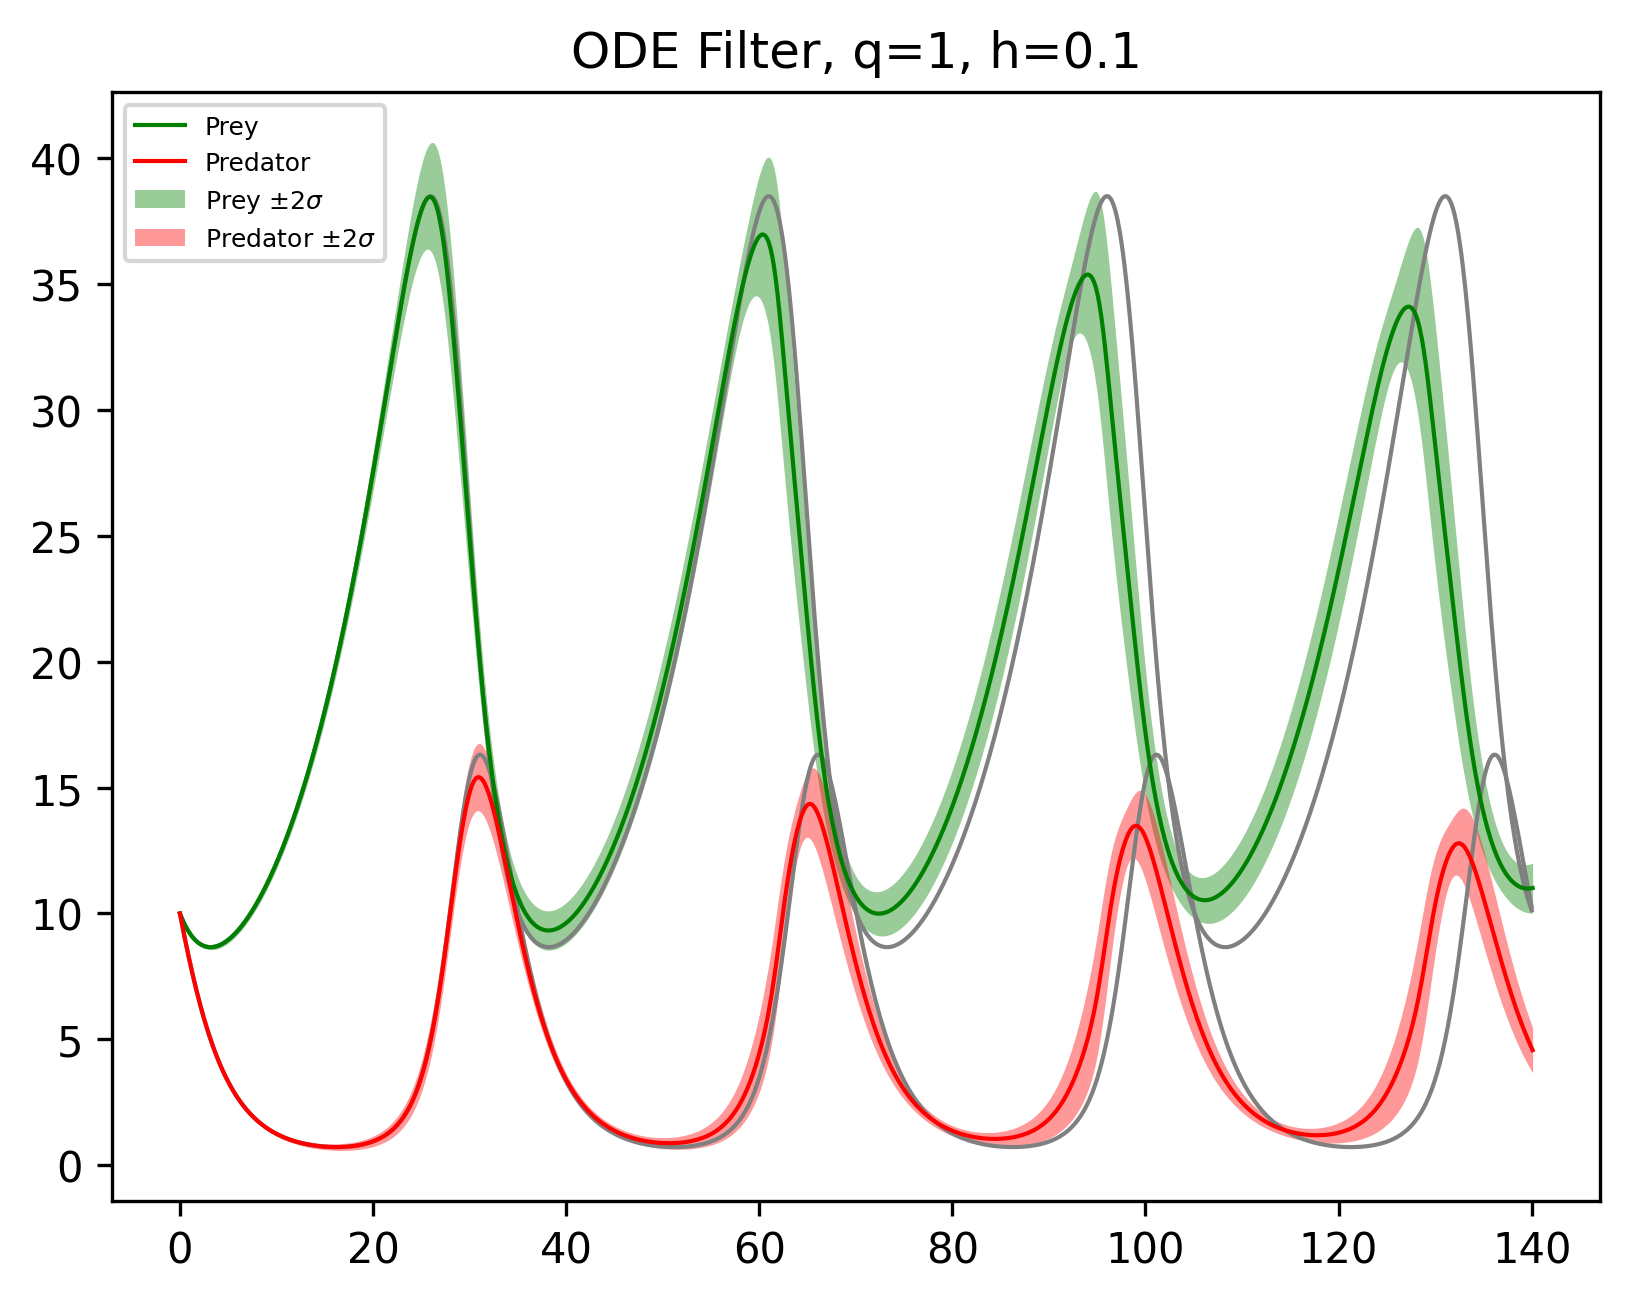

In [19]:
plot_lv_with_uncertainty(f_sol, c_sol=sol, title=f"ODE Filter, q={q}, h={h}")

### Smoother

Great, our filter seems to be working!

But, it only calculates the filtering distribution $p(x_n | z_{1:n})$.

As we can see above, this is pretty useful already (for smaller stepsizes than used above, it could actually provide a decently accurate solution).
However, at every $x_n$, it only considers information up to that time point.

We can also perform a smoothing pass, where we go backwards in time
to obtain the full smoothing posterior
$$ p(x_n | z_{1:N}) = \mathcal{N}(x_n; m_n^S, P_n^S) $$

#### Smoother step

We start with $m_N^S = m_N^f, P_N^S = P_N^f$ (ie. set the last smoothing parameters to the last filtering parameters), and then iteratively perform the step

\begin{align*}
    G_n &= P_n^f A(h_{n+1})^\top \left(P_{n+1}^p\right)^{-1} &\text{Gain} \\
    m_n^S &= m_n^f + G_n(m_{n+1}^S - m_{n+1}^p) &\text{smoothing mean} \\
    P_n^S &= P_n^f + G_n(P_{n+1}^S - P_{n+1}^p) G_n^\top &\text{smoothing cov}\,,
\end{align*}

which we can easily implement:

In [20]:
@partial(jax.jit, static_argnames=["d", "q"])
def smoother_step(
        m_f, P_f,
        m_p_next, P_p_next,
        m_s_next, P_s_next,
        H0, h, d, q):
    A = discrete_transition_matrix(d, q, h)
    G = P_f @ A.T @ jnp.linalg.inv(P_p_next)  # again, we'll improve this later.
    m_s = m_f + G @ (m_s_next - m_p_next)  # posterior smoothing mean
    P_s = P_f + G @ (P_s_next - P_p_next) @ G.T  # posterior smoothing cov
    y_s = H0 @ m_s  # Again extract current y and stddev
    stddev_s = jnp.sqrt(jnp.diag(H0 @ P_s @ H0.T))
    return m_s, P_s, y_s, stddev_s

And can already implement the our ODE smoother:

In [21]:
def ode_smoother(f_out):
    # Setup, retrieve parameters
    predictive_means = f_out["predictive_means"]
    predictive_covs = f_out["predictive_covs"]
    filtering_means = f_out["filtering_means"]
    filtering_covs = f_out["filtering_covs"]
    ts = f_out["ts"]
    N, d, q = len(ts), f_out["d"], f_out["q"]
    H0 = f_out["H0"]
    # Init. loop variables
    m_s_next = filtering_means[-1]
    P_s_next = filtering_covs[-1]
    smoothing_ts = [ts[-1]]  # Init. last smoothing parameters as last filtering parameters
    smoothing_ys = [f_out["ys"][-1]]
    smoothing_stddevs = [f_out["stddevs"][-1]]

    for n in range(N - 2, -1, -1):  # shift by 1 due to zero-based indexing
        # [N - 2, 0]
        # (N-1 is last, and that step was already initialized as the
        # last filtering parameters).
        # Predictive params hold one less element at the start,
        # so eg predictive_means[n] actually corresponds to m_p[n+1]
        m_p_next, P_p_next = predictive_means[n], predictive_covs[n]
        m_f, P_f = filtering_means[n], filtering_covs[n]
        t = ts[n]
        h = ts[n + 1] - t
        m_s, P_s, y, stddev = smoother_step(
            m_f, P_f, m_p_next, P_p_next, m_s_next, P_s_next, H0, h, d, q)
        # Store results
        smoothing_ts.insert(0, t)
        smoothing_ys.insert(0, y)
        smoothing_stddevs.insert(0, stddev)
        m_s_next, P_s_next = m_s, P_s

    return {
            "ts": jnp.asarray(smoothing_ts).squeeze(),
            "ys": jnp.asarray(smoothing_ys).squeeze(),
            "stddevs": jnp.asarray(smoothing_stddevs).squeeze()}

In [22]:
s_sol = ode_smoother(f_sol)

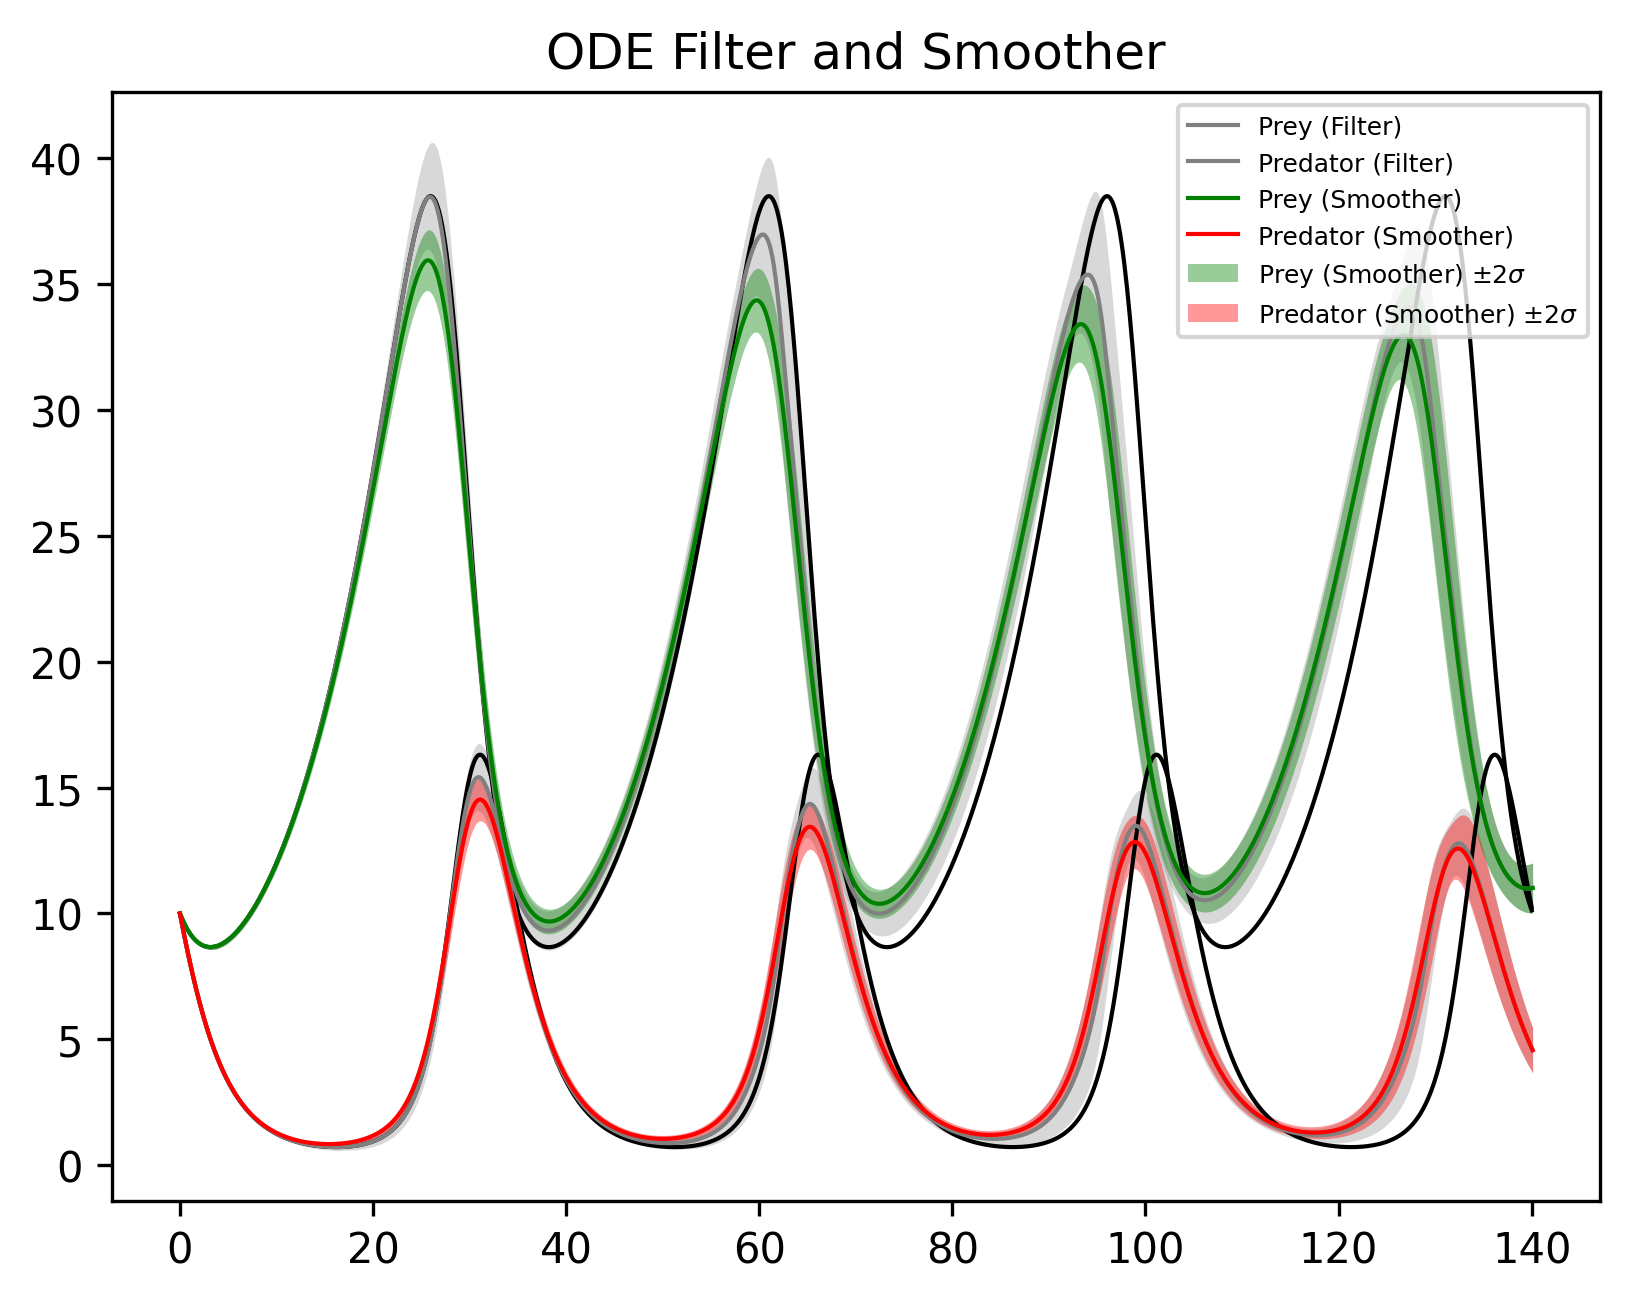

In [23]:
plot_filter_and_smoother(f_sol, s_sol, c_sol=sol, title=f"ODE Filter and Smoother")

### When to choose which?

We have now essentially implemented 4 algorithms at once:
- EKF0, EKS0, EKF1, EKS1
  - 0 or 1 determines constant or linear approximation of $f$ in the filter
  - EKF means filter only, EKS uses filter + smoother

The most accurate will likely be EKS1, due to the smoothing pass and the more accurate approximation of $f$.

But using one of the other variants could also be a good choice:
- If evaluating the jacobian of $f$ is expensive, EKS0 or EKF0 could be a reasonable choice
- If solving the ODE is expensive already/requires many steps, EKF0/1 could be a reasonable choice, as
  - The smoothing pass requires as many steps as the filtering path and
  - The filter itself can be implemented with constant memory (if you don't need to save every step for the smoother)

## Extending the simple implementation

### Uncertainty estimation

#### Calibrated Local Uncertainty

Remember the IWP scale $\sigma$ in [Dynamic model / State](#Dynamic-model-/-State)?

So far, we've just used $\sigma = 1$.

We can get a _local_ (quasi-ML) estimate $\hat{\sigma}_n^2$ via
$$ \hat{\sigma}_n^2 = \hat{z}_n^\top \left(H \tilde{Q}(h_n) H^\top \right)^{-1} \hat{z}_n^\top\,, $$
where $\tilde{Q}(h_n)$ is $Q(h_n)$ with $\sigma^2 = 1$
(as, remember, $Q(h_n)$ does depend on $\sigma^2$).

This is actually what the function ```discrete_diffusion_matrix(d, q, h)``` does
(and the reason why we ignored the factor $\sigma^2$).

So, for calibrated (local) uncertainty, we can just run the filter like before,
and, after we've calculated $\hat{z}_n$, we can get our uncertainty estimate $\hat{\sigma}_n^2$,
and just rescale $Q(h_n) = \hat{\sigma}_n^2 \tilde{Q}(h_n)$, and have calibrated local uncertainty!

In [24]:
def local_uncertainty(z_hat, H, Q):
    sigma_sq = z_hat.T @ jnp.linalg.inv(H @ Q @ H.T) @ z_hat
    return sigma_sq

#### Local Error Estimation

Additionally, we can now use our calibrated $Q(h_n) = \hat{\sigma}_n^2 \tilde{Q}(h_n)$
to obtain an estimate for the local error with
$$ D(h_n) = \sqrt{\tilde{H} Q(h_n) \tilde{H}^\top}\,, $$
which is essentially just the covariance of $\hat{z}_n$.

If we have a multi-dimensional ODE, then the above estimates an error per dimension.

I just took the max error as error estimate
- Although I'm not sure this is the best way to do this

In [25]:
def local_error(H_hat, Q):
    err = jnp.sqrt((H_hat @ Q @ H_hat.T).max())
    return err

#### Step size adaptation

Being able to adapt the step size $h_n$ is very beneficial:
- For some steps, the solver could have to use a very small step size
  - Especially so for _stiff_ ODEs
  - Potentially so small that solving over an interval of interest
    could become almost infeasible
- Whereas in other intervals, the solver can get away with taking
  relatively large steps
  - Huge performance gains possible

For example, the basic solver we constructed earlier is able to solve
the Lotka-Volterra system pretty accurately, but we'd need a smaller step size,
eg. $h = 0.01$, instead of $h = 0.1$, but:
- This then takes 10 times longer,
  - and requires 10 times as much memory (if using the smoother or not saving only at fixed
    points)

This is often done by specifying a (relative) tolerance, and trying to take
steps as large as possible while keeping the error within tolerance.

For our implementation, this means:
- Perform the filter step as usual, but
  - report the local error and
  - computing the next step size based on the current local error
- If the error is too large, we _reject_ the step,
  and try again using the step size from above (that would otherwise have been used for the
  next step)

There are many possibilities for computing the next step size,
we implemented _proportional control_:
$$ h_n^{\text{next}} = h_n \rho \left(\frac{\varepsilon}{D(h_n)}\right)^{\frac{1}{q+1}}\,, $$
where $\epsilon$ is the tolerance, and $\rho \in (0, 1]$ is a safety factor.

We use:
- $\rho = 0.9$
- And we clamp $0.2 \leq \rho \left(\frac{\varepsilon}{D(h_n)}\right)^{\frac{1}{q+1}} \leq 10 $
- (These are the same as in the 2021 paper listed in the references)

In [26]:
def next_stepsize(h, q, err, reltol,
                  stepsize_safety_factor,
                  stepsize_min_change, stepsize_max_change):
    stepsize_factor = (
        stepsize_safety_factor
        * (reltol / err) ** (1.0 / (q + 1.0)))
    stepsize_factor = jax.lax.clamp(
        stepsize_min_change, stepsize_factor, stepsize_max_change)
    return h * stepsize_factor

Let's add all of these changes to ```ode_filter()```:

In [27]:
@partial(jax.jit, static_argnames=["f", "f_args", "d", "q", "ekf_order"])
def ode_filter_step(m_f_prev, P_f_prev, f, f_args,
                    t_prev, h, d, q,
                    H0, H, R, ekf_order,
                    reltol, stepsize_safety_factor,
                    stepsize_min_change, stepsize_max_change):
    t = t_prev + h
    A = discrete_transition_matrix(d, q, h)
    Q = discrete_diffusion_matrix(d, q, h)

    # predict (mean only)
    m_p = A @ m_f_prev
    # residual
    z_hat, H_hat = residual(f, t, m_p, H, H0, f_args, ekf_order)

    # local uncertainty est.
    sigma_sq = local_uncertainty(z_hat, H, Q)
    Q = sigma_sq * Q  # update Q
    err = local_error(H_hat, Q)  # est. local error
    h_next = next_stepsize(h, q, err, reltol,
                           stepsize_safety_factor,
                           stepsize_min_change, stepsize_max_change)

    P_p = A @ P_f_prev @ A.T + Q  # predictive cov with updated Q
    m_f, P_f = next_filtering_mean_and_cov(m_p, P_p, z_hat, H_hat, R)

    y = H0 @ m_f
    stddev = jnp.sqrt(jnp.diag(H0 @ P_f @ H0.T))
    return m_f, P_f, m_p, P_p, y, stddev, err, h_next

In [28]:
# With optional adaptive step size and calibrated uncertainty
def ode_filter(y0, f, f_args,
               t0, t1,
               q,  # order
               h0,
               adaptive_stepsize=True,
               reltol=1e-3,
               stepsize_safety_factor=0.9,
               stepsize_min_change=0.2,
               stepsize_max_change=10.0,
               ekf_order=1):
    h0, t0 = jnp.array(h0), jnp.array(t0)  # Ensure these are arrays
    reltol = jnp.array(reltol)
    stepsize_safety_factor = jnp.array(stepsize_safety_factor)
    stepsize_min_change = jnp.array(stepsize_min_change)
    stepsize_max_change = jnp.array(stepsize_max_change)
    d = y0.shape[-1]  # dimension of y
    # Initialization
    x0 = initial_state(f, t0, y0, q, f_args)
    stddev0 = jnp.zeros_like(y0)
    P0 = jnp.diag(jnp.repeat(stddev0, q + 1))  # Assume zero initial cov.
    H0, H = ssm_projection_matrices(d, q)
    # R=0 -> dirac measure on initial value
    R = jnp.zeros((d, d))
    # Init. objects for storing results
    rejected_steps = 0
    accepted_steps = 0
    ts, ys, stddevs = [t0], [y0], [stddev0]
    filtering_means, filtering_covs, predictive_means, predictive_covs = [x0], [P0], [], []
    # Init. loop variables
    t_prev, h = t0, h0
    m_f_prev, P_f_prev = x0, P0  # Filtering parameters (of previous step)

    # ODE filter loop
    while t_prev < t1:
        m_f, P_f, m_p, P_p, y, stddev, err, h_next = \
            ode_filter_step(m_f_prev, P_f_prev, f, f_args,
                            t_prev, h, d, q,
                            H0, H, R, ekf_order,
                            reltol, stepsize_safety_factor,
                            stepsize_min_change, stepsize_max_change)
        # Here's the important change
        if adaptive_stepsize:
            if err > reltol:
                # Reject current step, try again
                h = h_next
                rejected_steps += 1
                continue
        else:
            # Do not adapt step size
            h_next = h
        accepted_steps += 1
        # Store results
        t = t_prev + h
        ts.append(t)
        ys.append(y)
        stddevs.append(stddev)
        filtering_means.append(m_f)
        filtering_covs.append(P_f)  # These should be calibrated now
        predictive_means.append(m_p)
        predictive_covs.append(P_p)
        # Update loop variables
        t_prev, m_f_prev, P_f_prev = t, m_f, P_f
        # Update step size
        h = h_next

    # Return results in dict
    return {
        "ts": jnp.asarray(ts).squeeze(),
        "ys": jnp.asarray(ys).squeeze(),
        "stddevs": jnp.asarray(stddevs).squeeze(),
        "predictive_means": predictive_means,
        "predictive_covs": predictive_covs,
        "filtering_means": filtering_means,
        "filtering_covs": filtering_covs,
        "num_accepted": accepted_steps, "num_rejected": rejected_steps,
        "H0": H0, "d": d, "q": q}

Note that none of the changes made so far change anything about the smoother,
we can still use the implementation from earlier.

Let's test it!

In [29]:
q = 1
h0 = 1e-2  # Initial step size, shouldn't be too large but otherwise doesn't matter much
ekf_order = 1
f_adaptive_sol = ode_filter(
    y0, lotka_volterra_vf, lv_args,
    t0, t1, q, h0, ekf_order=ekf_order,
    reltol=1e-2,
    adaptive_stepsize=True)

Rejected: 0, Accepted: 9594


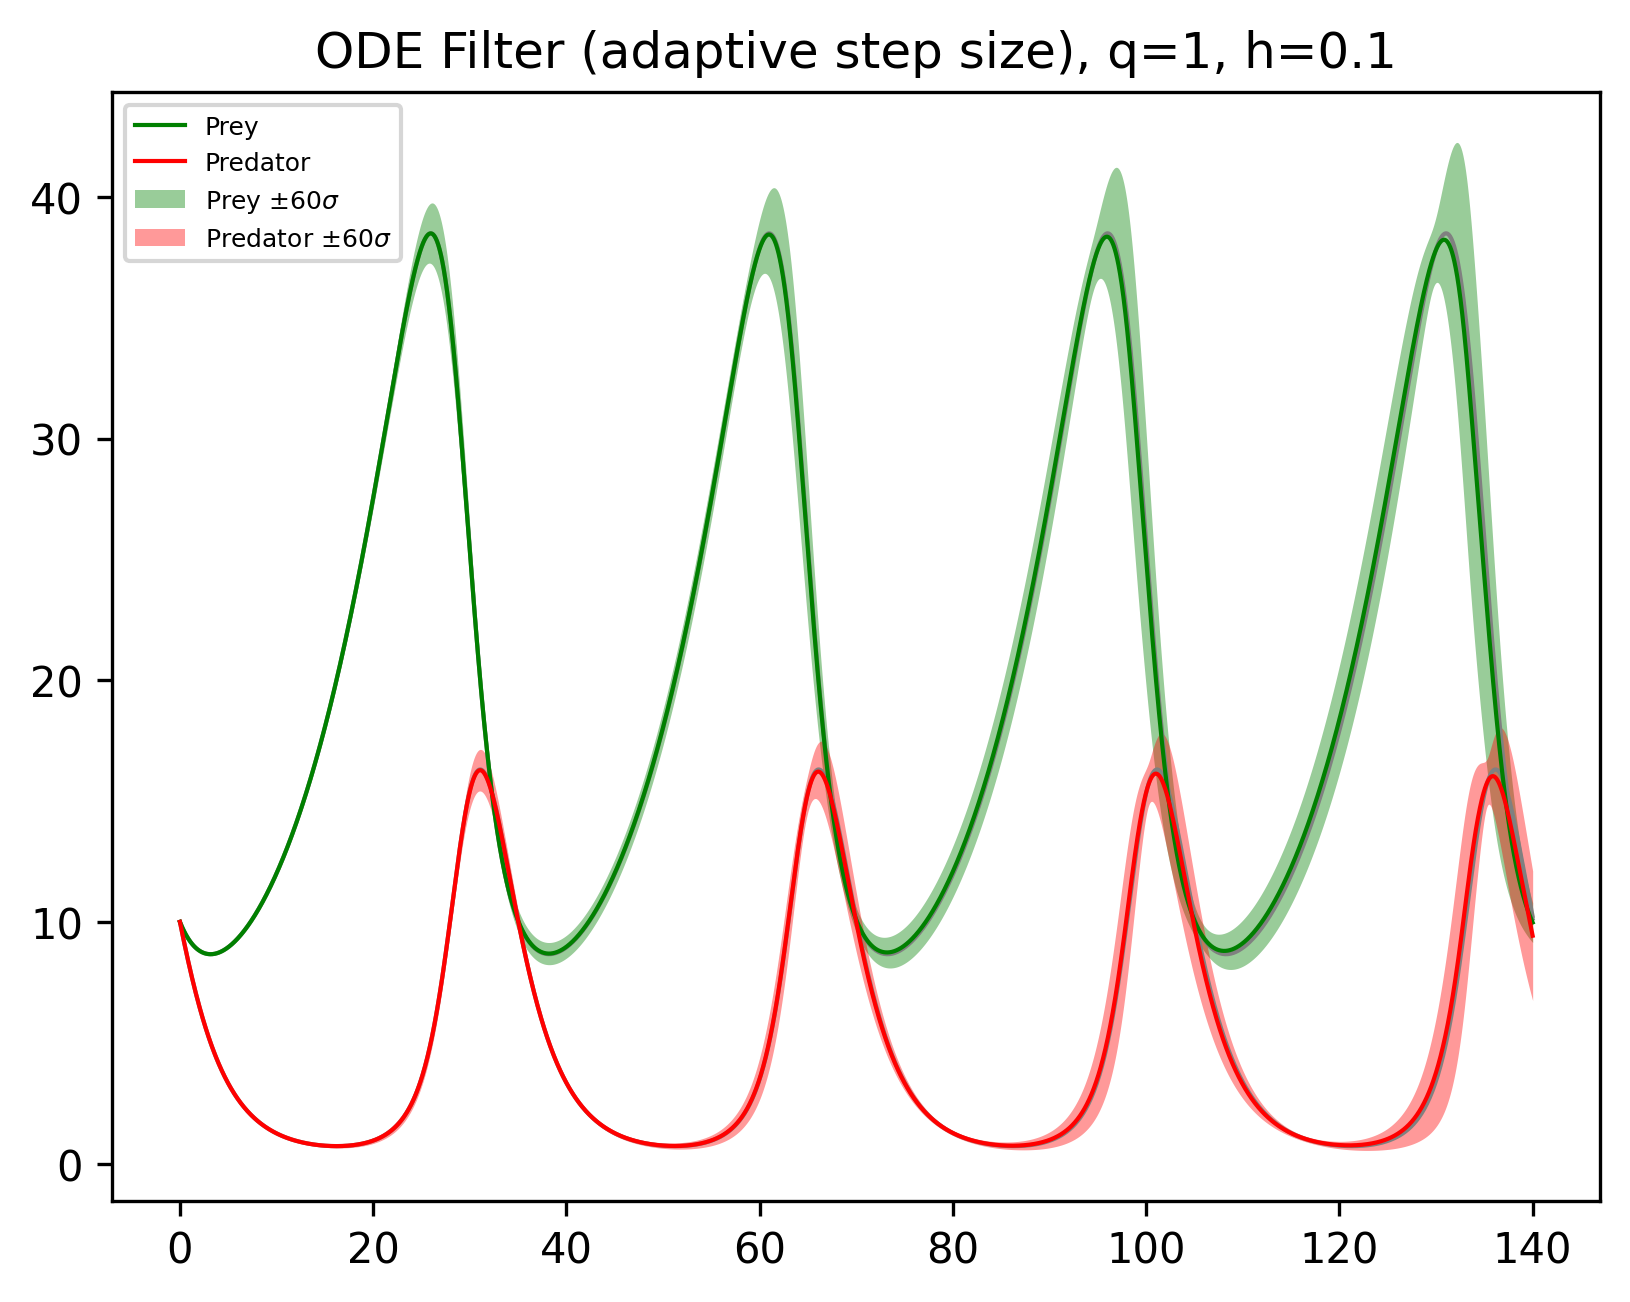

In [30]:
print(f"Rejected: {f_adaptive_sol["num_rejected"]}, Accepted: {f_adaptive_sol["num_accepted"]}")
n_stddevs = 60
plot_lv_with_uncertainty(f_adaptive_sol, c_sol=sol, num_stddevs=n_stddevs, title=f"ODE Filter (adaptive step size), q={q}, h={h}")

#### NOTE:

Above, we didn't actually get an improvement, in fact,
in that setting, the solver performs _worse_ than without
adaptive step size.
- By worse I mean that it does more steps and is less accurate than
  without adaptive step size
- This _could_ mean that there's an issue with the implementation

If we use order $q=2$, then the solver can benefit from our added
adaptive_stepsize option (improve over constant stepsize).

In [31]:
q = 2 # For order 2 (or higher), it works
h0 = 1e-1  # Initial step size, shouldn't be too large but otherwise doesn' matter
ekf_order = 1
f_adaptive_sol = ode_filter(
    y0, lotka_volterra_vf, lv_args,
    t0, t1, q, h0, ekf_order=ekf_order,
    reltol=1e-2,
    adaptive_stepsize=True)

Rejected: 23, Accepted: 566


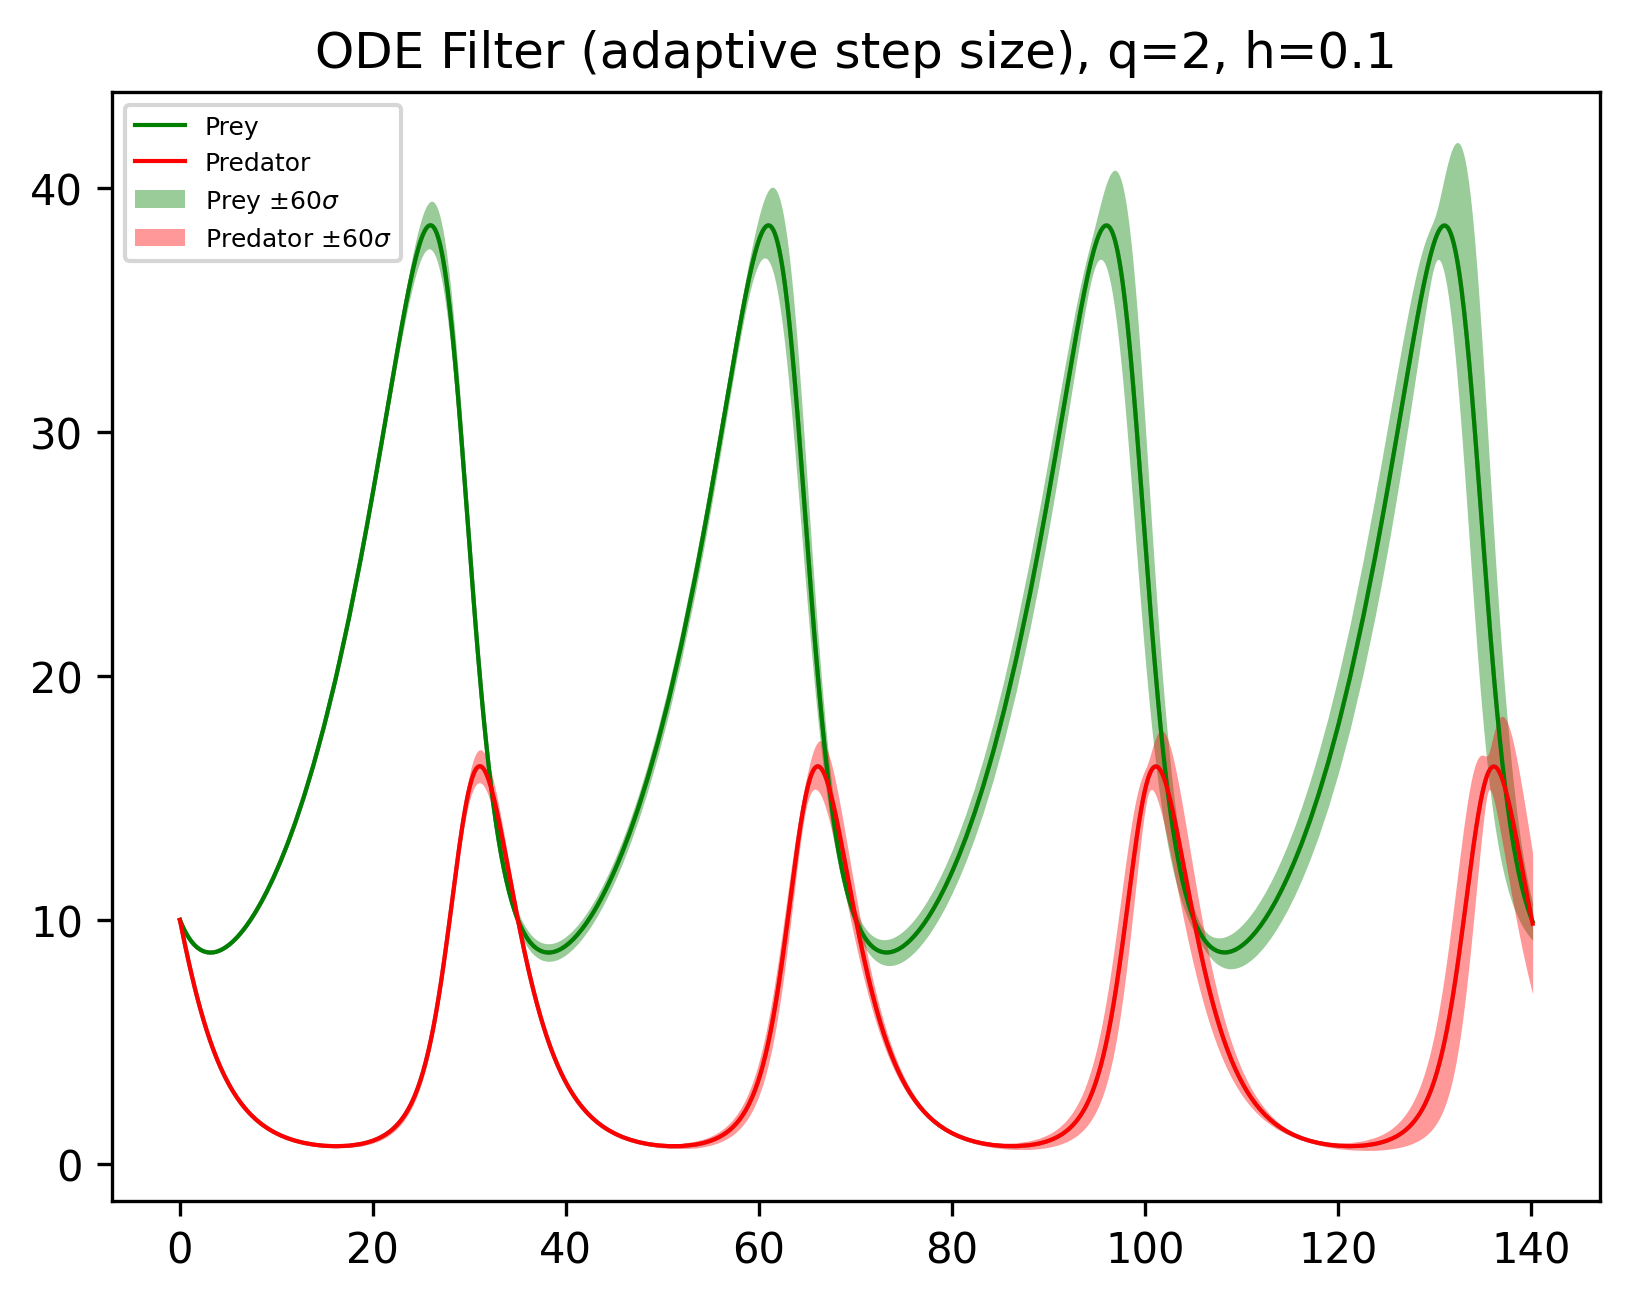

In [32]:
print(f"Rejected: {f_adaptive_sol["num_rejected"]}, Accepted: {f_adaptive_sol["num_accepted"]}")
n_stddevs = 60
plot_lv_with_uncertainty(f_adaptive_sol, c_sol=sol, num_stddevs=n_stddevs, title=f"ODE Filter (adaptive step size), q={q}, h={h}")

### Improving numerical Stability

The covariance matrices (and diffusion matrix $Q$)
are a big source of instability, because:

- eg. $Q(h) = Q(h)_{i,j} = \sigma^2 \frac{h^{2q + 3 - i - j}}{(2q + 3 - i - j)(q + 1 - i)!(q +1 - j)!}$ is very ill-conditioned
- Due to numerical inaccuracy, it might happen that the covariance matrices could have
  negative eigenvalues, ie. are not positive definite anymore
- We also need to invert them in some places

Here are two ways to improve stability of the solver:

#### Nordsieck Rescaling

We re-scale the state space at every step by
$$ T_n = \sqrt{h_n} \text{diag}\begin{pmatrix} \frac{h^q}{q!} & \frac{h^{q-1}}{(q-1)!} & \cdots & h & 1 \end{pmatrix}\,, $$
so eg. we model
$$ p(x_{n+1} | x_n) = \mathcal{N}(x_{n+1}; T_n A(h_n) T_n^{-1} x_n, T_n Q(h_n) T_n^\top)\,. $$
This means that we store $x_n$ normally, but whenever we do inference,
we scale it by $\bar{x}_n = T_n^{-1} x_n$ to work in the transformed space instead,
and then re-scale it back at the end by multiplying with $T_n$.

One of the advantages of performing inference in the scaled space is that
\begin{align*}
    A(h_n) &= T_n \bar{A} T_n^{-1} \\
    \bar{A}_{i,j} &= \begin{pmatrix} q + 1 - i \\ q + 1 - j \end{pmatrix}
\end{align*}
and
\begin{align*}
    Q(h_n) &= T_n \bar{Q} T_n^\top \\
    \bar{Q}_{i,j} &= \frac{1}{2q + 3 - i - j}\,,
\end{align*}
so we can use $\bar{A}, \bar{Q}$ in the transformed space instead.

Particularly, $\bar{Q}$ is _way_ less ill-conditioned than before,
and both $\bar{A}$ and $\bar{Q}$ do not depend on the step size anymore.

New constructors for $\bar{A}$ and $\bar{Q}$:

In [33]:
def discrete_transition_matrix_ns(d, q):
    K = q - np.repeat(np.expand_dims(np.arange(q + 1), 0), q + 1, 0)
    A = jnp.triu(scipy.special.comb(K.T, K)).astype(float)
    return jnp.kron(A, jnp.eye(d))

def discrete_diffusion_matrix_ns(d, q):
    Q_j = jnp.stack((jnp.arange(q + 1) + 1,) * (q + 1))
    Q = 1.0 / (2 * q + 3 - Q_j.T - Q_j)
    return jnp.kron(Q, jnp.eye(d))

And a function for computing $T_n$ and $T_n^{-1}$:

In [34]:
def nordsieck_coord_transformation(d, q, h):
    qs = jnp.flip(jnp.arange(q + 1), 0)
    T_diag = jnp.sqrt(h) * (h ** qs / jax.scipy.special.factorial(qs))
    T_inv_diag = 1.0 / T_diag
    T = jnp.kron(jnp.diag(T_diag), jnp.eye(d))
    T_inv = jnp.kron(jnp.diag(T_inv_diag), jnp.eye(d))
    return T, T_inv

As $f$ works in the non-transformed space, we of course also have to
de-scale before evaluating $f$, and re-scale afterwards:

In [35]:
def residual(f, t, m_p, H, H0, T, f_args, ekf_order):
    m_p0 = H0 @ T @ m_p  # de-scale for f
    f_at_m_p = f(t, m_p0, f_args)
    if ekf_order == 0:
        H_hat = H
    else:
        J_f = jax.jacfwd(f, argnums=1)(t, m_p0, f_args)
        H_hat = H - J_f @ H0  # regular * in 1-d case
    z_hat = f_at_m_p - H @ T @ m_p  # residual
    H_hat = H_hat @ T
    return z_hat, H_hat

#### Square-Root Kalman Filter

The problem regarding the positive definite-ness of the covariance matrices
can be mitigated by not working on them directly,
but instead on their matrix square-roots. For example:
$$ Q = L_Q L_Q^\top $$

The Cholesky decomposition presents itself as a useful tool for this
($L_Q L_Q^\top$ is a Cholesky decomposition of $Q$),
it factorizes a (real) matrix into this form, such that $L_Q$ is lower-triangular.

We can now formulate the Kalman filter using only the triangular factors $L_Q$
(same as for all other covariance matrices we work on),
which guarantees that eg. $L_Q L_Q^\top = Q$ will always be symmetric positive definite
whenever we want to reconstruct it.

On top of that, for all matrices we had to invert before,
we also get a decomposition into triangular matrices
- We can compute the inverse of that factor by forward/backward-substitution
- This is faster _and_ more stable than directly inverting the original matrix

For example, the predictive mean and covariance during the filter step can be calculated like this:
\begin{align*}
    \bar{m}_n^f &= T_n^{-1} m_n^f  &\text{scale filtering mean} \\
    \bar{L}_n^f &= T_n^{-1} L_n^f  &\text{scale filtering cov factor} \\
    \bar{m}_{n+1}^p &= \bar{A} \bar{m_n}^f  &\text{next predictive mean} \\
    \begin{pmatrix} \bar{A}\bar{L}_n^f & L_Q \end{pmatrix}^\top &= XR_{n+1} &\text{see below}\\
    \bar{L}_{n+1}^p &= (R_{n+1})_{0:d(q+1)}^\top &\text{next predictive cov factor}
\end{align*}
Where $XR_{n+1}$ is a QR-decomposition of $\begin{pmatrix} \bar{A}\bar{L}_n^f & L_Q \end{pmatrix}^\top$, of which we don't need $X$, and $\bar{L}_{n+1}^p$ is the
top $(d(q+1)\times d(q+1))$ block of $R_{n+1}$  (transposed, as due to the QR-decomposition,
$R_{n+1}$ is upper-triangular).

It can be implemented as follows:

In [36]:
def predict(m_f, A, L_f, L_Q, T_inv):
    m_f = T_inv @ m_f
    L_f = T_inv @ L_f
    m_p = A @ m_f
    C_p_pre = jnp.vstack([(A @ L_f).T, L_Q.T])  # the stack (AL, L_Q)^\top
    L_p = jax.scipy.linalg.qr(C_p_pre, mode="economic")[1].T
    return m_p, L_p

### Final implementation including all of the listed improvements

#### ODE Filter

(Assuming $R=0$ for simplicity)

In [37]:
def cho_cov_to_stddev(L, H0):
    # Helper function for extracting sttdev from cholesky cov factor
    return jnp.sqrt(jnp.diag(H0 @ L @ L.T @ H0.T))

def predictive_cov(A, L_f, L_Q):
    C_p_pre = jnp.vstack([(A @ L_f).T, L_Q.T])
    L_p = jax.scipy.linalg.qr(C_p_pre, mode="economic")[1].T
    return L_p

def local_error(L_Q, H_hat):
    return jnp.sqrt((H_hat @ L_Q @ L_Q.T @ H_hat.T).max())

def next_filtering_mean_and_cov(m_p, L_p, z_hat, H_hat):
    # Kalman filter statistics
    S_pre = (H_hat @ L_p).T
    L_S = jax.scipy.linalg.qr(S_pre, mode="economic")[1].T  # innovation cov factor
    C_cross = L_p @ L_p.T @ H_hat.T
    # invert L_S by solving a linear system,
    # ie backward substitution as it's lower triangular
    L_S_inv = jax.scipy.linalg.solve_triangular(L_S, jnp.eye(L_S.shape[0]), lower=True)
    K = C_cross @ L_S_inv.T @ L_S_inv  # Kalman gain
    # Next filtering mean/cov
    m_f = m_p + K @ z_hat  # + or plus here?
    L_f = (jnp.eye(L_p.shape[1]) - K @ H_hat) @ L_p
    return m_f, L_f

In [38]:
@partial(jax.jit, static_argnames=["f", "f_args", "d", "q", "adaptive_stepsize", "ekf_order"])
def ode_filter_step(
        m_f_prev, L_f_prev,
        f, f_args,
        t, h,
        d, q,
        A, L_Q_hat,  # pass A, L_Q as they are now constant
        H0, H,
        z_error_scale,
        reltol,
        adaptive_stepsize,
        stepsize_safety_factor,
        stepsize_min_change,
        stepsize_max_change,
        ekf_order):
    T, T_inv = nordsieck_coord_transformation(d, q, h)
    # scale previous filtering parameters
    m_f_prev = T_inv @ m_f_prev
    L_f_prev = T_inv @ L_f_prev

    m_p = A @ m_f_prev  # predictive mean
    z_hat, H_hat = residual(f, t, m_p, H, H0, T, f_args, ekf_order=ekf_order)
    # See filter function for explanation of z_error_scale
    sigma_hat = z_error_scale * z_hat.T @ z_hat
    # Update L_Q with local uncertainty estimate
    L_Q = jnp.sqrt(sigma_hat) * L_Q_hat
    L_p = predictive_cov(A, L_f_prev, L_Q)

    m_f, L_f = next_filtering_mean_and_cov(m_p, L_p, z_hat, H_hat)
    m_f = T @ m_f  # de-scale output
    L_f = T @ L_f
    y = H0 @ m_f  # extract y and stddev
    stddev = cho_cov_to_stddev(L_f, H0)

    err = local_error(L_Q, H_hat)
    h_next = next_stepsize(h, q, err, reltol,
                           stepsize_safety_factor,
                           stepsize_min_change, stepsize_max_change)

    return m_f, L_f, m_p, L_p, y, stddev, err, h_next

And we finally get the filter

In [39]:
def ode_filter(
        y0,
        f, f_args,
        t0, t1,
        q, h0,
        reltol=1e-3,
        adaptive_stepsize=True,
        stepsize_safety_factor=0.9,
        stepsize_min_change=0.2,
        stepsize_max_change=10.0,
        ekf_order=1):
    h0, t0 = jnp.array(h0), jnp.array(t0)  # Ensure these are arrays
    reltol = jnp.array(reltol)
    stepsize_safety_factor = jnp.array(stepsize_safety_factor)
    stepsize_min_change = jnp.array(stepsize_min_change)
    stepsize_max_change = jnp.array(stepsize_max_change)
    d = y0.shape[-1]  # dimension of y
    # Initialization
    x0 = initial_state(f, t0, y0, q, f_args)
    stddev0 = jnp.zeros_like(y0)
    L_P0 = jnp.diag(jnp.repeat(stddev0, q + 1))  # Assume zero initial cov.
    H0, H = ssm_projection_matrices(d, q)
    # R=0 -> dirac measure on initial value
    # Init. objects for storing results
    rejected_steps = 0
    accepted_steps = 0
    ts, ys, stddevs = [t0], [y0], [stddev0]
    filtering_means, filtering_covs, predictive_means, predictive_covs = [x0], [L_P0], [], []
    # Init. loop variables
    t_prev, h = t0, h0
    m_f_prev, L_f_prev = x0, L_P0  # Filtering parameters (of previous step)

    A = discrete_transition_matrix_ns(d, q)
    Q = discrete_diffusion_matrix_ns(d, q)
    L_Q = jnp.linalg.cholesky(Q)  # cholesky-factorize Q
    # the (H @ Q(1) @ H)^{-1} part of the local error term
    # reduces to the below error_scale * Id, so this simplifies a lot
    z_error_scale = jnp.array(2 * q - 1.0)

    # ODE filter loop
    while t_prev < t1:
        m_f, L_f, m_p, L_p, y, stddev, err, h_next = \
                ode_filter_step(m_f_prev, L_f_prev, f, f_args, t_prev, h, d, q,
                                A, L_Q, H0, H,
                                z_error_scale,
                                reltol,
                                adaptive_stepsize=adaptive_stepsize,
                                stepsize_safety_factor=stepsize_safety_factor,
                                stepsize_min_change=stepsize_min_change,
                                stepsize_max_change=stepsize_max_change,
                                ekf_order=ekf_order)
        if adaptive_stepsize:
            if err > reltol:
                # Reject current step, try again
                h = h_next
                rejected_steps += 1
                continue
        else:
            # Do not adapt step size
            h_next = h
        accepted_steps += 1
        # Store results
        t = t_prev + h
        ts.append(t)
        ys.append(y)
        stddevs.append(stddev)
        filtering_means.append(m_f)
        filtering_covs.append(L_f)
        predictive_means.append(m_p)
        predictive_covs.append(L_p)
        # Update loop variables
        t_prev, m_f_prev, L_f_prev = t, m_f, L_f
        # Update step size
        h = h_next

    # Format and return results
    return {
        "ts": jnp.asarray(ts).squeeze(),
        "ys": jnp.asarray(ys).squeeze(),
        "stddevs": jnp.asarray(stddevs).squeeze(),
        "predictive_means": predictive_means,
        "predictive_covs": predictive_covs,
        "filtering_means": filtering_means,
        "filtering_covs": filtering_covs,
        "num_accepted": accepted_steps, "num_rejected": rejected_steps,
        "H0": H0, "d": d, "q": q,
        "A": A, "L_Q": L_Q}

In [40]:
# IMPORTANT NOTE: This has an error somewhere
@partial(jax.jit, static_argnames=["d", "q"])
def smoother_step(
        m_f, L_f,
        m_p_next, L_p_next,
        m_s_next, L_s_next,
        A, L_Q, H0, h, d, q):
    T, T_inv = nordsieck_coord_transformation(d, q, h)
    # Apply the transformation
    m_f = T_inv @ m_f
    L_f = T_inv @ L_f
    m_s_next = T_inv @ m_s_next
    L_s_next = T_inv @ L_s_next
    # Invert L_p more efficiently
    L_p_inv = jax.scipy.linalg.solve_triangular(
            L_p_next, jnp.eye(L_p_next.shape[0]), lower=True)
    G = L_f @ (A @ L_f).T @ L_p_inv.T @ L_p_inv  # gain
    m_s = m_f + G @ (m_s_next - m_p_next)  # posterior mean
    # Smoothing cov factor
    L_s_pre = jnp.hstack([
        (jnp.eye(A.shape[0]) - G @ A) @ L_f,
        G @ L_Q,
        G @ L_s_next]).T
    L_s = jax.scipy.linalg.qr(L_s_pre, mode="economic")[1].T
    # Transform back
    m_s = T @ m_s
    L_s = T @ L_s
    # Extract y and stddev
    y_s = H0 @ m_s
    stddev_s = cho_cov_to_stddev(L_s, H0)
    return m_s, L_s, y_s, stddev_s

In [41]:
def ode_smoother(f_out):
    # Setup, retrieve parameters
    predictive_means = f_out["predictive_means"]
    predictive_covs = f_out["predictive_covs"]
    filtering_means = f_out["filtering_means"]
    filtering_covs = f_out["filtering_covs"]
    ts = f_out["ts"]
    N, d, q = len(ts), f_out["d"], f_out["q"]
    A, L_Q, H0 = f_out["A"], f_out["L_Q"], f_out["H0"]
    # Init. loop variables
    m_s_next = filtering_means[-1]
    L_s_next = filtering_covs[-1]
    smoothing_ts = [ts[-1]]  # Init. last smoothing parameters as last filtering parameters
    smoothing_ys = [f_out["ys"][-1]]
    smoothing_stddevs = [f_out["stddevs"][-1]]

    for n in range(N - 2, -1, -1):
        m_p_next, L_p_next = predictive_means[n], predictive_covs[n]
        m_f, L_f = filtering_means[n], filtering_covs[n]
        t = ts[n]
        h = ts[n + 1] - t
        m_s, L_s, y, stddev = smoother_step(
            m_f, L_f, m_p_next, L_p_next, m_s_next, L_s_next, A, L_Q, H0, h, d, q)
        # Store results
        smoothing_ts.insert(0, t)
        smoothing_ys.insert(0, y)
        smoothing_stddevs.insert(0, stddev)
        m_s_next, L_s_next = m_s, L_s

    return {
            "ts": jnp.asarray(smoothing_ts).squeeze(),
            "ys": jnp.asarray(smoothing_ys).squeeze(),
            "stddevs": jnp.asarray(smoothing_stddevs).squeeze()}

Test our final solver:

In [42]:
q = 5   # Use 5-th order (which would have, in this case,
        # also worked before improving numerical stability).
h0 = 0.1
ekf_order = 1
f_stability_sol = ode_filter(
    y0, lotka_volterra_vf, lv_args,
    t0, t1, q, h0, ekf_order=ekf_order,
    reltol=1e-3,
    adaptive_stepsize=True)

s_stability_sol = ode_smoother(f_stability_sol)

Rejected: 23, Accepted: 566


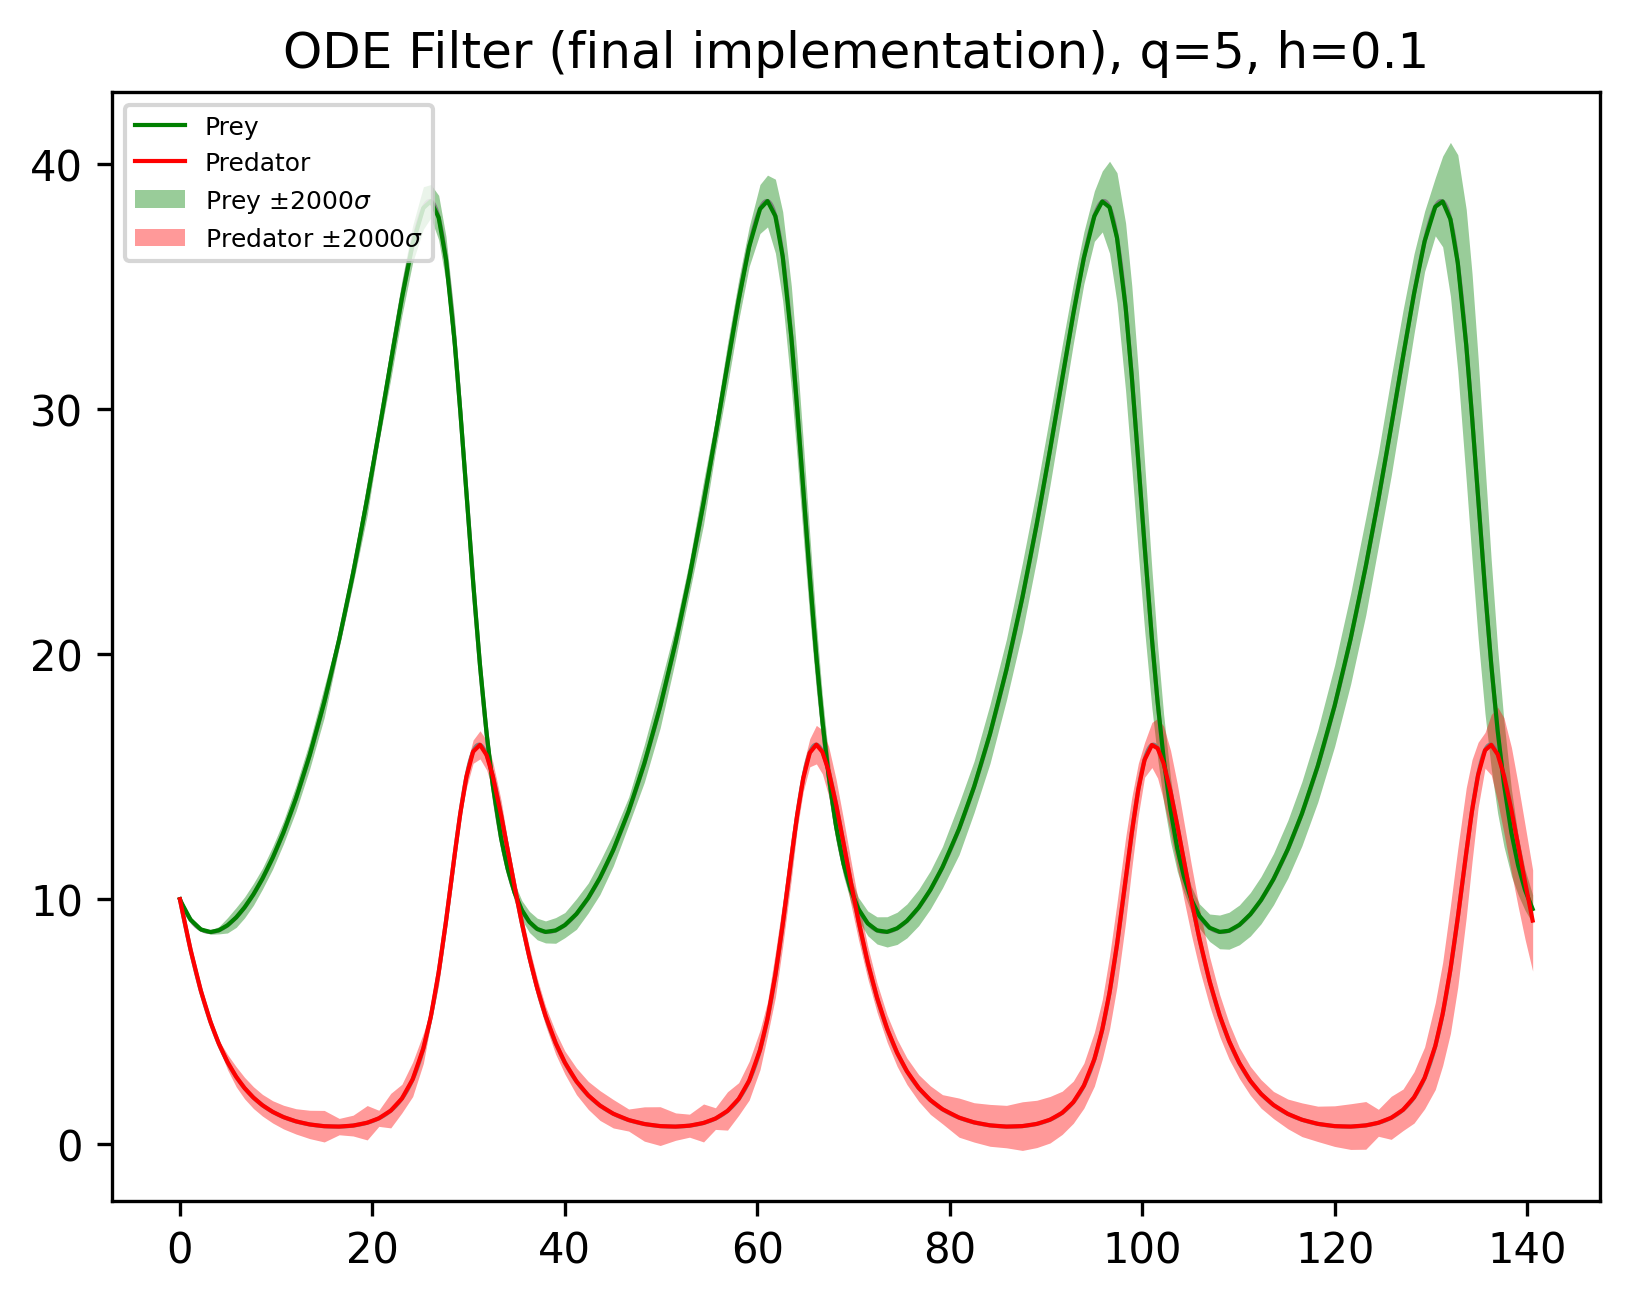

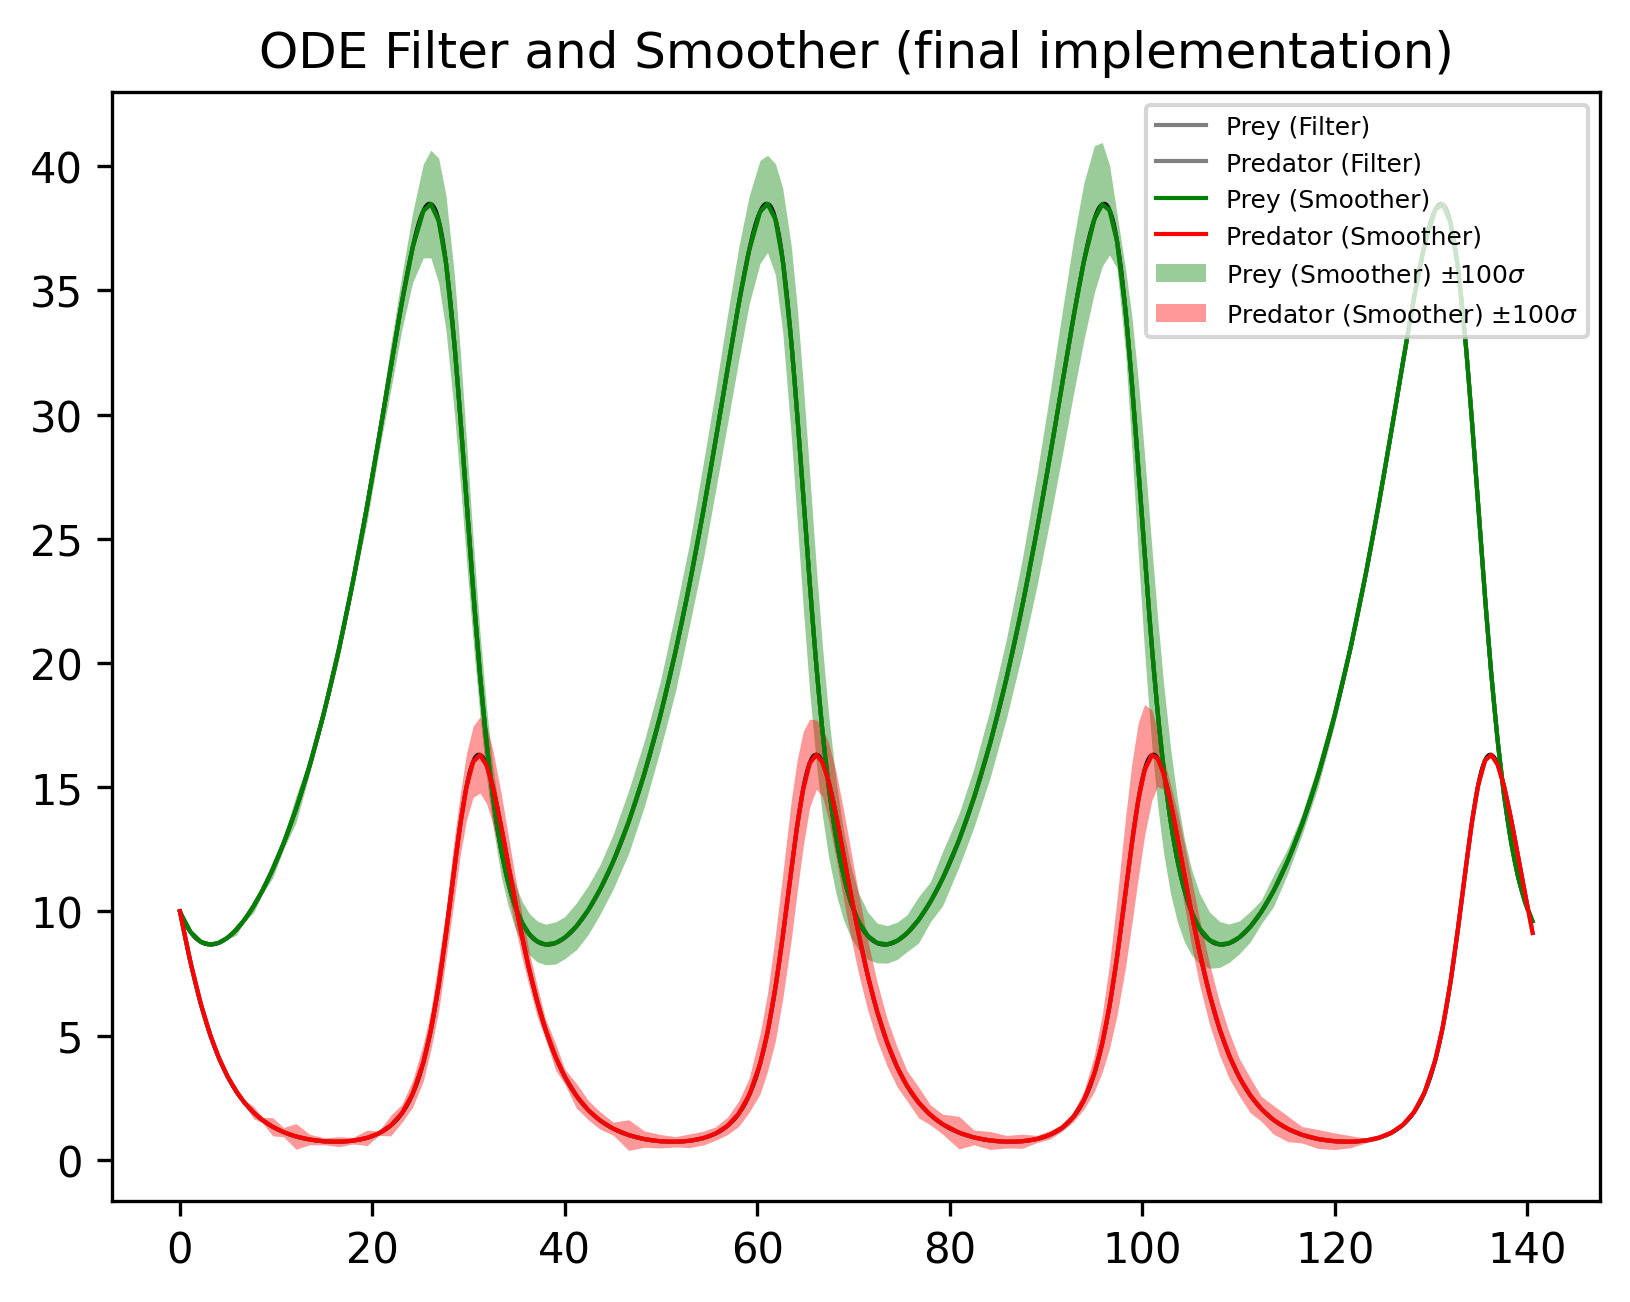

In [43]:
print(f"Rejected: {f_adaptive_sol["num_rejected"]}, Accepted: {f_adaptive_sol["num_accepted"]}")
n_stddevs_f = 2000
n_stddevs_s = 100
plot_lv_with_uncertainty(f_stability_sol, c_sol=sol, num_stddevs=n_stddevs_f,
                         title=f"ODE Filter (final implementation), q={q}, h={h}")
plot_filter_and_smoother(f_stability_sol, s_stability_sol, c_sol=sol, num_stddevs=n_stddevs_s,
                         title=f"ODE Filter and Smoother (final implementation)")

NOTE: There's an error somewhere in the smoother_step() function,
but I wasn't able to find/fix it.
I've included the code for the final smoother anyways;
the error causes (as can be seen above in the __very__ different scaling of the uncertainty) the smoothing covariance
to be too large (near beginning/end, ie. where it currently seems as if there were no uncertainty, it's actually correct, I believe it's too large everywhere else).